# Fetching Data

In [19]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sn

In [4]:
root_path = "WESAD"
zip_label = "_E4_Data.zip"
E4_label = "_E4_Data"

In [5]:
pacient_state = {
    0: "Not Defined/Transient",
    1: "Baseline",
    2: "Stress",
    3: "Amusement",
    4: "Meditation",
    5: "Error/Not Labeled"
}

In [6]:
chest_signal_available = ['ECG', 'EMG', 'EDA', 'Temp', 'Resp']

In [7]:
subjects_available = os.listdir(root_path)

subjects_available

['S5',
 'S2',
 'S3',
 'S4',
 '.DS_Store',
 'S17',
 'S10',
 'S11',
 'S16',
 'S8',
 'S6',
 'S7',
 'S9',
 'S13',
 'S14',
 'S15']

In [8]:
try:
    subjects_available.remove(".DS_Store")
except:
    print(subjects_available)

print(subjects_available)

['S5', 'S2', 'S3', 'S4', 'S17', 'S10', 'S11', 'S16', 'S8', 'S6', 'S7', 'S9', 'S13', 'S14', 'S15']


In [9]:
def get_input_chest_data(subjects_list):
    
    chest_df_list = []
    
    for subject in subjects_list:
        
        pkl_path = os.path.join(root_path, subject, subject + ".pkl")
        f=open(pkl_path,'rb')
        data=pickle.load(f,encoding='latin1')
        
        index_df = [i for i in range(1, len(data["label"]) + 1)]

        chest_data = {
            body_signal: data["signal"]["chest"][body_signal].reshape(len(data["signal"]["chest"][body_signal]),)
            for body_signal in chest_signal_available
        }
        chest_data["label_id"] = [label if (label >= 0) and (label < 6) else 5 for label in data["label"]]
        chest_data["label"] = [pacient_state[label] if (label >= 0) and (label < 6) else pacient_state[5] for label in data["label"]]
        chest_data["subject"] = data["subject"]

        chest_df_list.append(pd.DataFrame(chest_data, index = index_df))
        
    return chest_df_list

In [10]:
input_chest_data = get_input_chest_data(subjects_available)

# Investigating Data

In [11]:
sample_df = input_chest_data[0]

sample_df.sample(20)

,ECG,EMG,EDA,Temp,Resp,label_id,label,subject
861909,-0.032730,-0.010574,3.694916,34.781555,-0.108337,1,Baseline,S5
1511002,-0.129272,-0.017715,5.526352,34.943298,-1.707458,3,Amusement,S5
149214,0.076492,0.011948,6.709290,34.353546,3.102112,0,Not Defined/Transient,S5
206346,-0.043533,-0.010620,6.084061,34.367340,7.786560,1,Baseline,S5
1737320,-0.074387,-0.002014,8.782196,34.944824,10.736084,5,Error/Not Labeled,S5
786325,-0.023895,0.012863,3.701019,34.796967,-2.067566,1,Baseline,S5
116318,-0.047241,0.026505,6.879425,34.199249,-4.295349,0,Not Defined/Transient,S5
3794088,-0.225494,-0.029160,7.637405,34.532715,-4.107666,0,Not Defined/Transient,S5
2083836,-0.085098,-0.002335,5.377579,34.966431,1.048279,4,Meditation,S5
2971121,-0.094986,-0.015976,9.709167,34.595642,9.870911,2,Stress,S5


In [12]:
sample_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ECG,4380600.0,0.001121,0.250579,-1.499359,-0.064636,-0.026321,0.017899,1.499954
EMG,4380600.0,-0.003708,0.015883,-0.732056,-0.010391,-0.003159,0.003525,0.331833
EDA,4380600.0,7.307906,2.320313,3.402710,5.461502,7.151794,9.448624,12.734604
Temp,4380600.0,34.702957,0.226590,33.850616,34.568024,34.755402,34.872375,35.461884
Resp,4380600.0,0.055553,4.303221,-25.990295,-2.285767,-0.465393,2.394104,33.428955
label_id,4380600.0,1.232982,1.547393,0.000000,0.000000,1.000000,2.000000,5.000000


In [13]:
sample_df["label_id"].unique()

array([0, 1, 5, 3, 4, 2])

<AxesSubplot:>

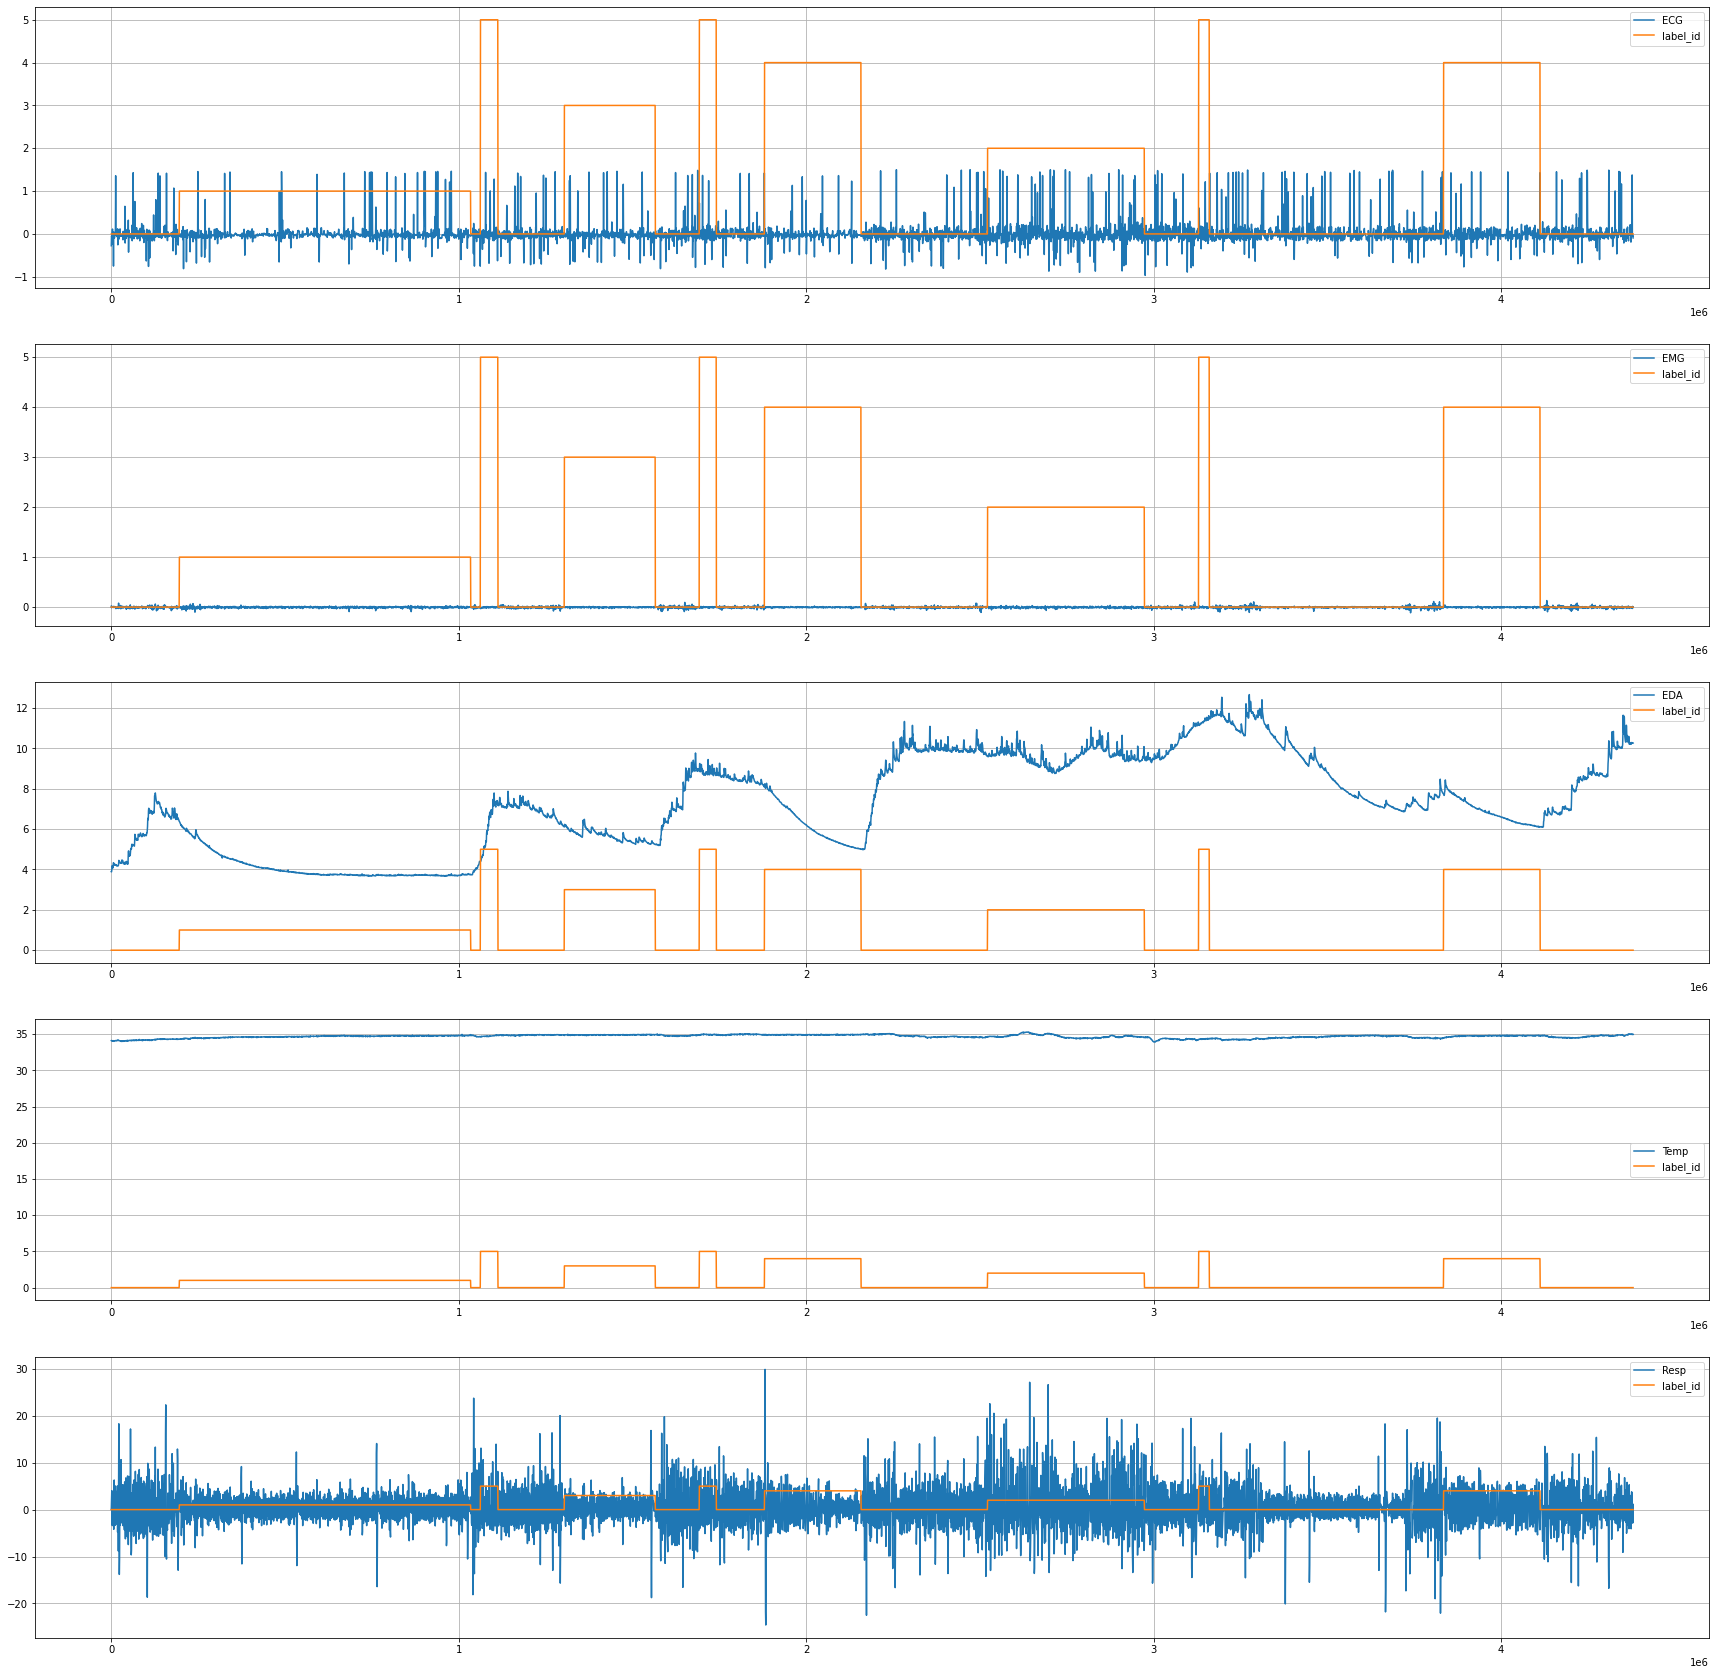

In [14]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1)

sample_df[::700].plot(figsize=(30, 30), grid=True, y=["ECG", "label_id"], ax=ax1)
sample_df[::700].plot(figsize=(30, 30), grid=True, y=["EMG", "label_id"], ax=ax2)
sample_df[::700].plot(figsize=(30, 30), grid=True, y=["EDA", "label_id"], ax=ax3)
sample_df[::700].plot(figsize=(30, 30), grid=True, y=["Temp", "label_id"], ax=ax4)
sample_df[::700].plot(figsize=(30, 30), grid=True, y=["Resp", "label_id"], ax=ax5)

In [15]:
from numpy.fft import rfft, irfft, rfftfreq
from scipy import pi, signal, fftpack

In [16]:
def annot_max(x, y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "x={:.3f}, y={:.3f}".format(xmax, ymax) 
    #text = f"{xmax=}, {ymax=}, (period: {1./xmax} days)" #Eh, Colab has Python 3.6 ... 
    text = f"x={xmax:.3f}, y={ymax:.3f}, (period: {(1./xmax):.2f} )"
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax),  xytext=(0.94, 0.96), **kw)

In [17]:
def plot_fft(signal, signal_name=""):
    plt.rcdefaults()

    nobs = len(signal)
    signal_ft = np.abs(rfft(signal))
    signal_freq = rfftfreq(nobs)

    plt.figure(figsize=(20,2))
    plt.plot(signal_freq[2:], signal_ft[2: ])
    annot_max(signal_freq[2:], signal_ft[2: ])
    plt.grid()

    plt.ylabel(f"{signal_name}")
    plt.xlabel('frequency')
    plt.show()

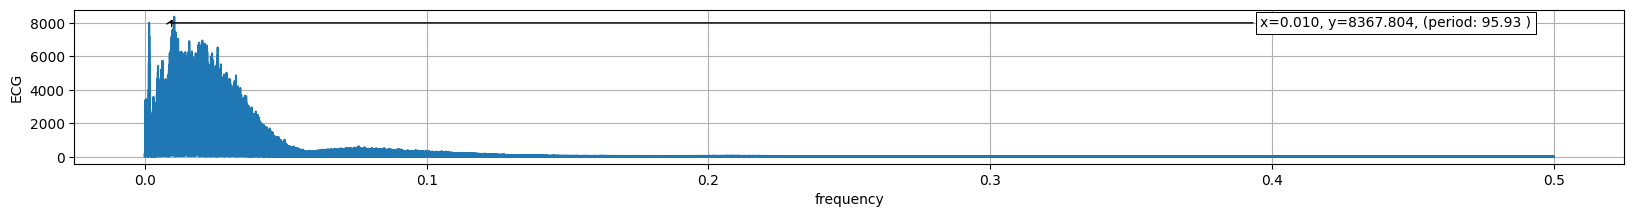

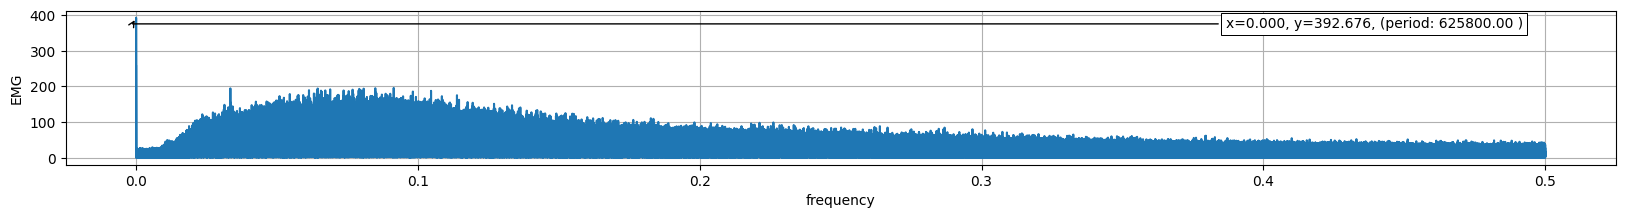

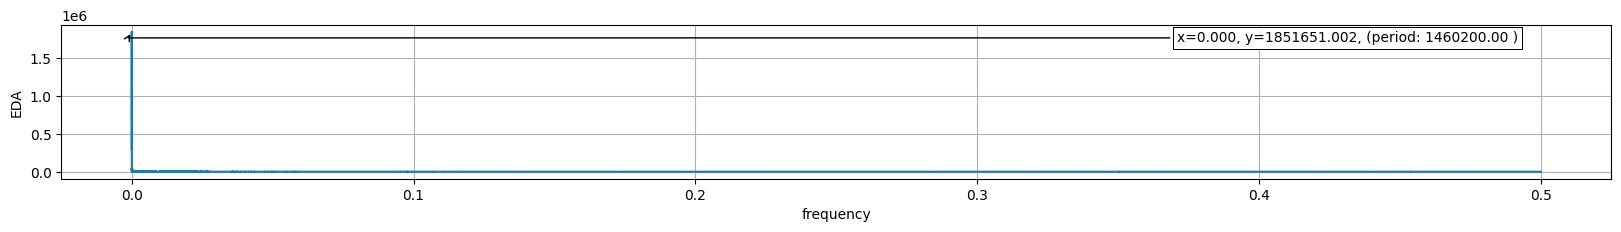

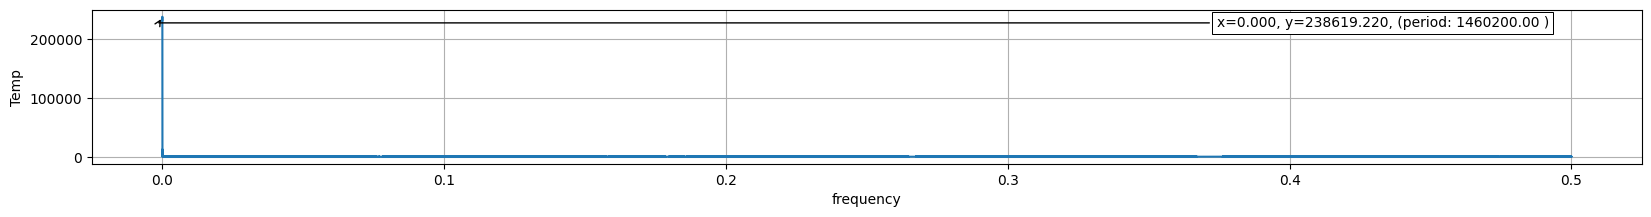

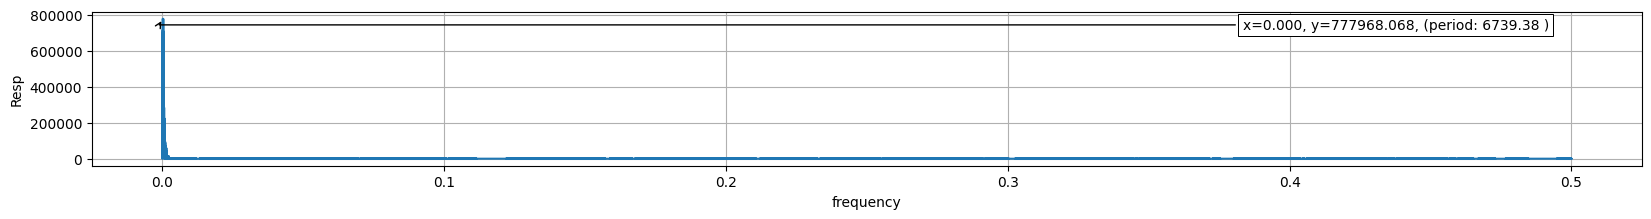

In [20]:
for signal in sample_df.columns:
    if (signal != "label_id" and signal != "label" and signal != "subject"):
        plot_fft(sample_df[signal], signal)

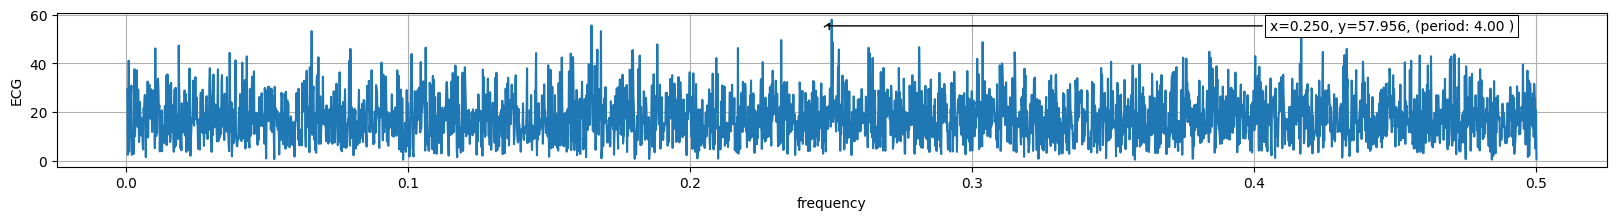

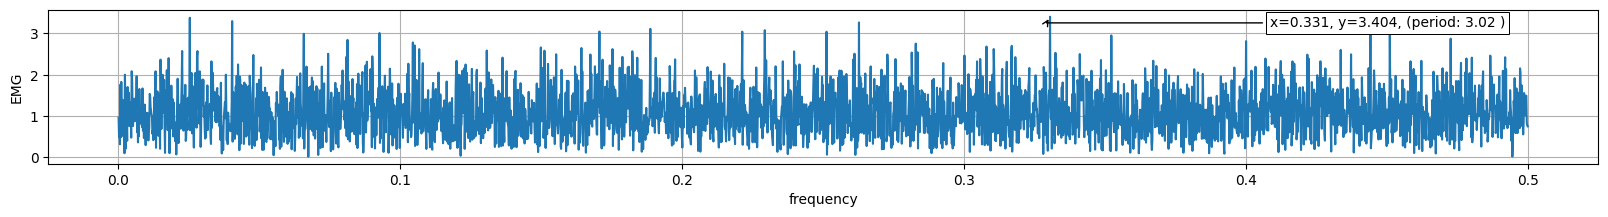

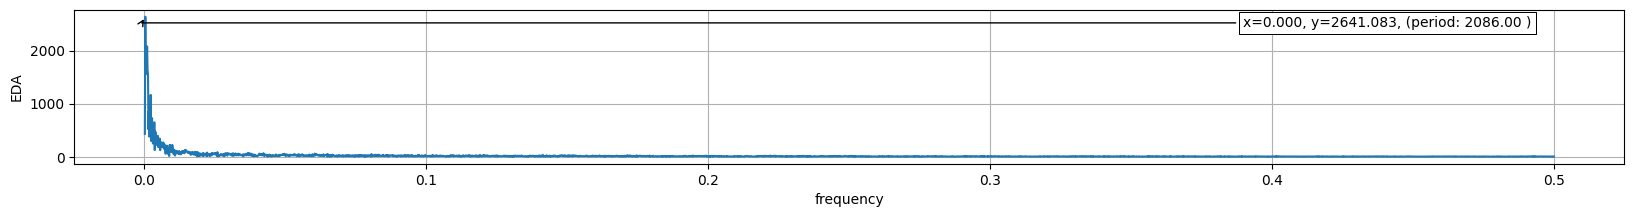

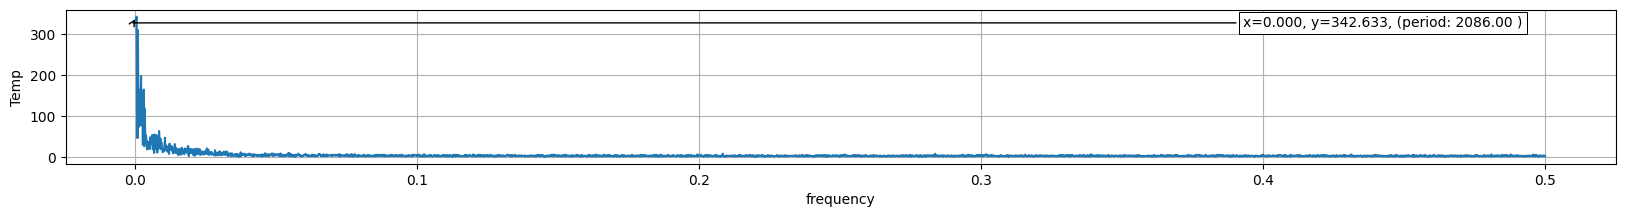

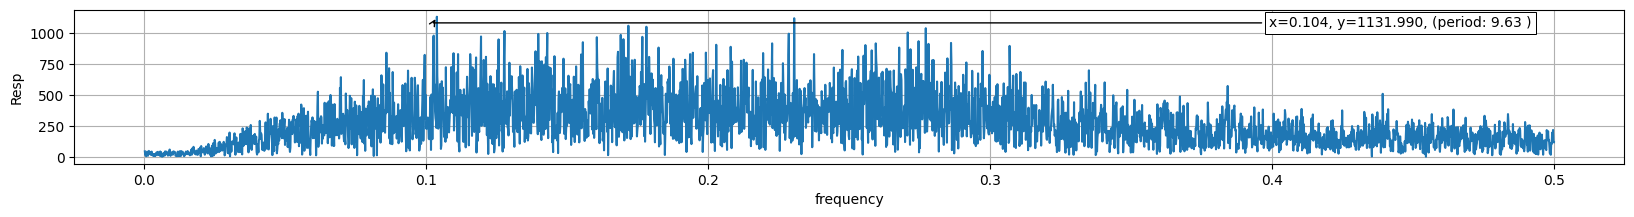

In [21]:
for signal in sample_df.columns:
    if (signal != "label_id" and signal != "label" and signal != "subject"):
        plot_fft(sample_df[signal][::700], signal)

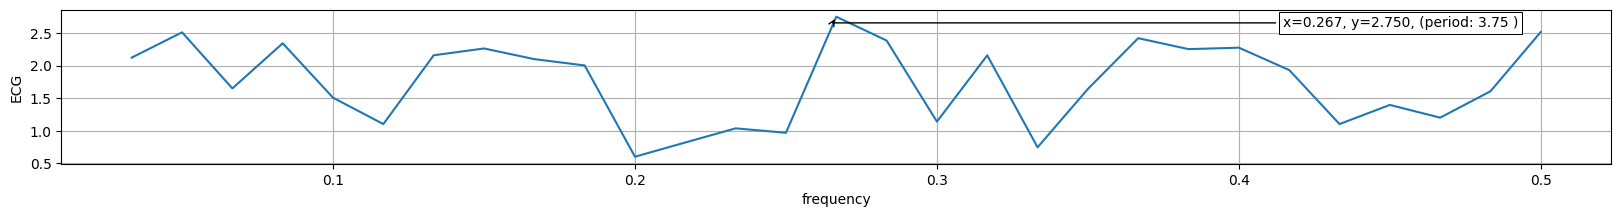

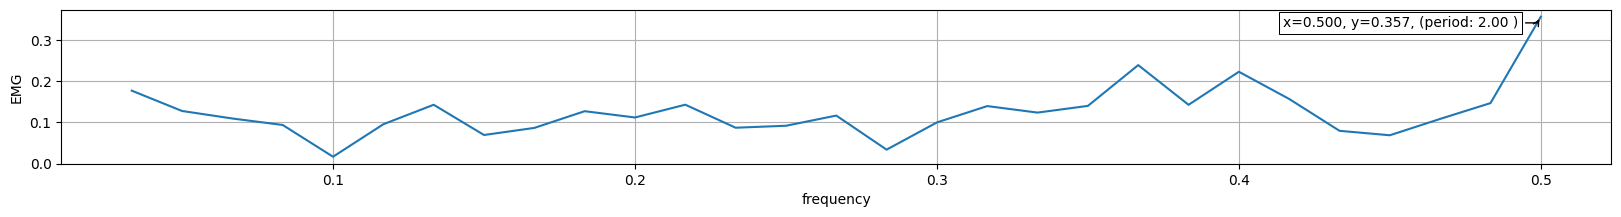

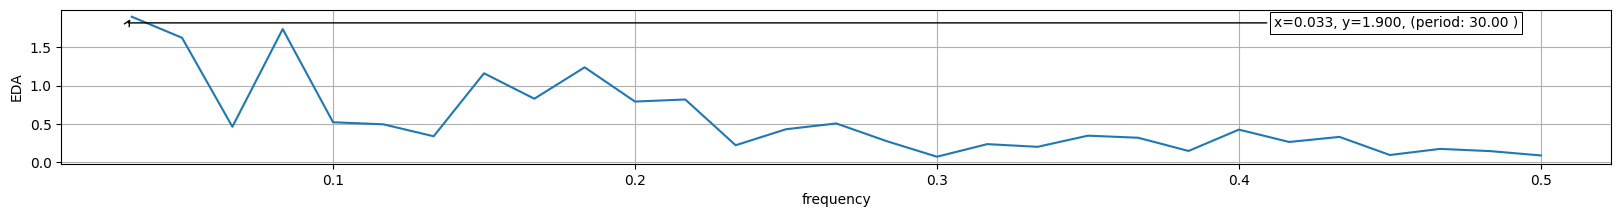

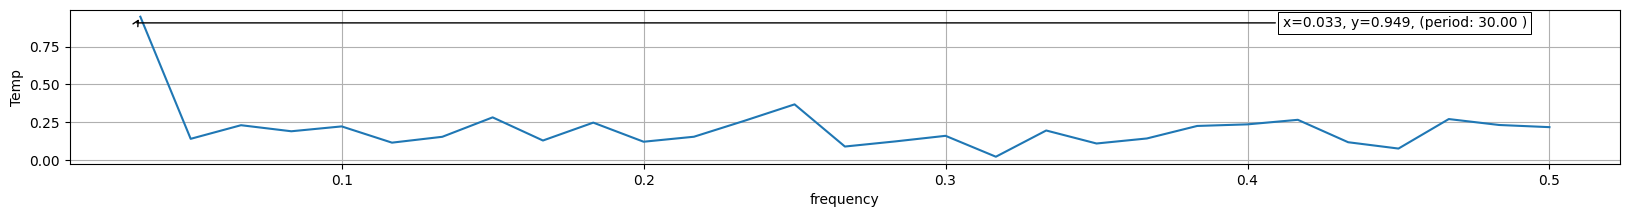

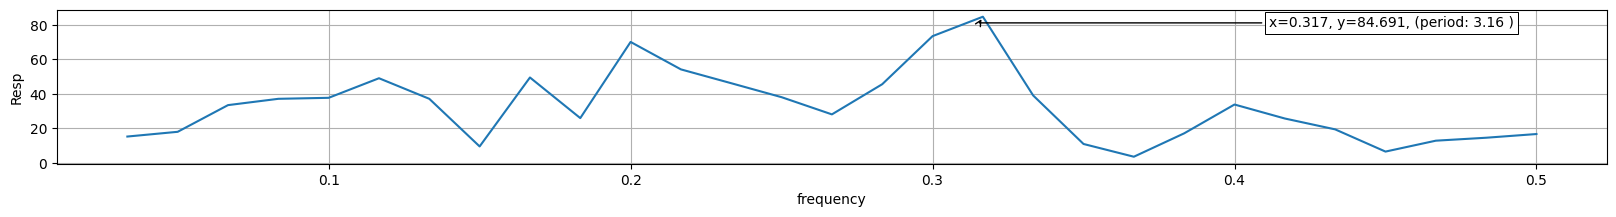

In [22]:
for signal in sample_df.columns:
    if (signal != "label_id" and signal != "label" and signal != "subject"):
        plot_fft(sample_df[signal][::700][:60], signal)

In [23]:
def low_pass(s, threshold=2e4):
    fourier = rfft(s)
    frequencies = rfftfreq(s.size, d=2e-3 / s.size)
    display(1/frequencies)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

In [24]:
teste = low_pass(sample_df["ECG"])

/var/folders/7_/2_zd275d5mv2_2m6k8c0cqmc0000gq/T/ipykernel_32496/1828417720.py:4: RuntimeWarning: divide by zero encountered in true_divide
  display(1/frequencies)


array([           inf, 2.00000000e-03, 1.00000000e-03, ...,
       9.13117758e-10, 9.13117342e-10, 9.13116925e-10])

In [25]:
teste

array([0.00109905, 0.00109906, 0.00109907, ..., 0.00109902, 0.00109903,
       0.00109904])

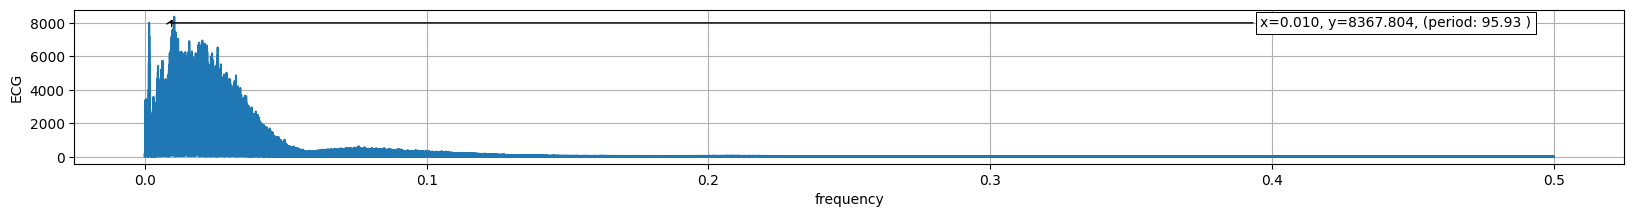

In [26]:
plot_fft(sample_df["ECG"], "ECG")

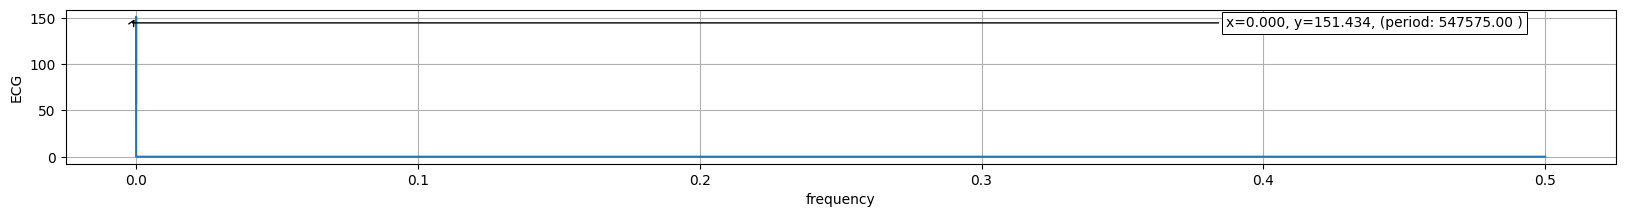

In [27]:
plot_fft(teste, "ECG")

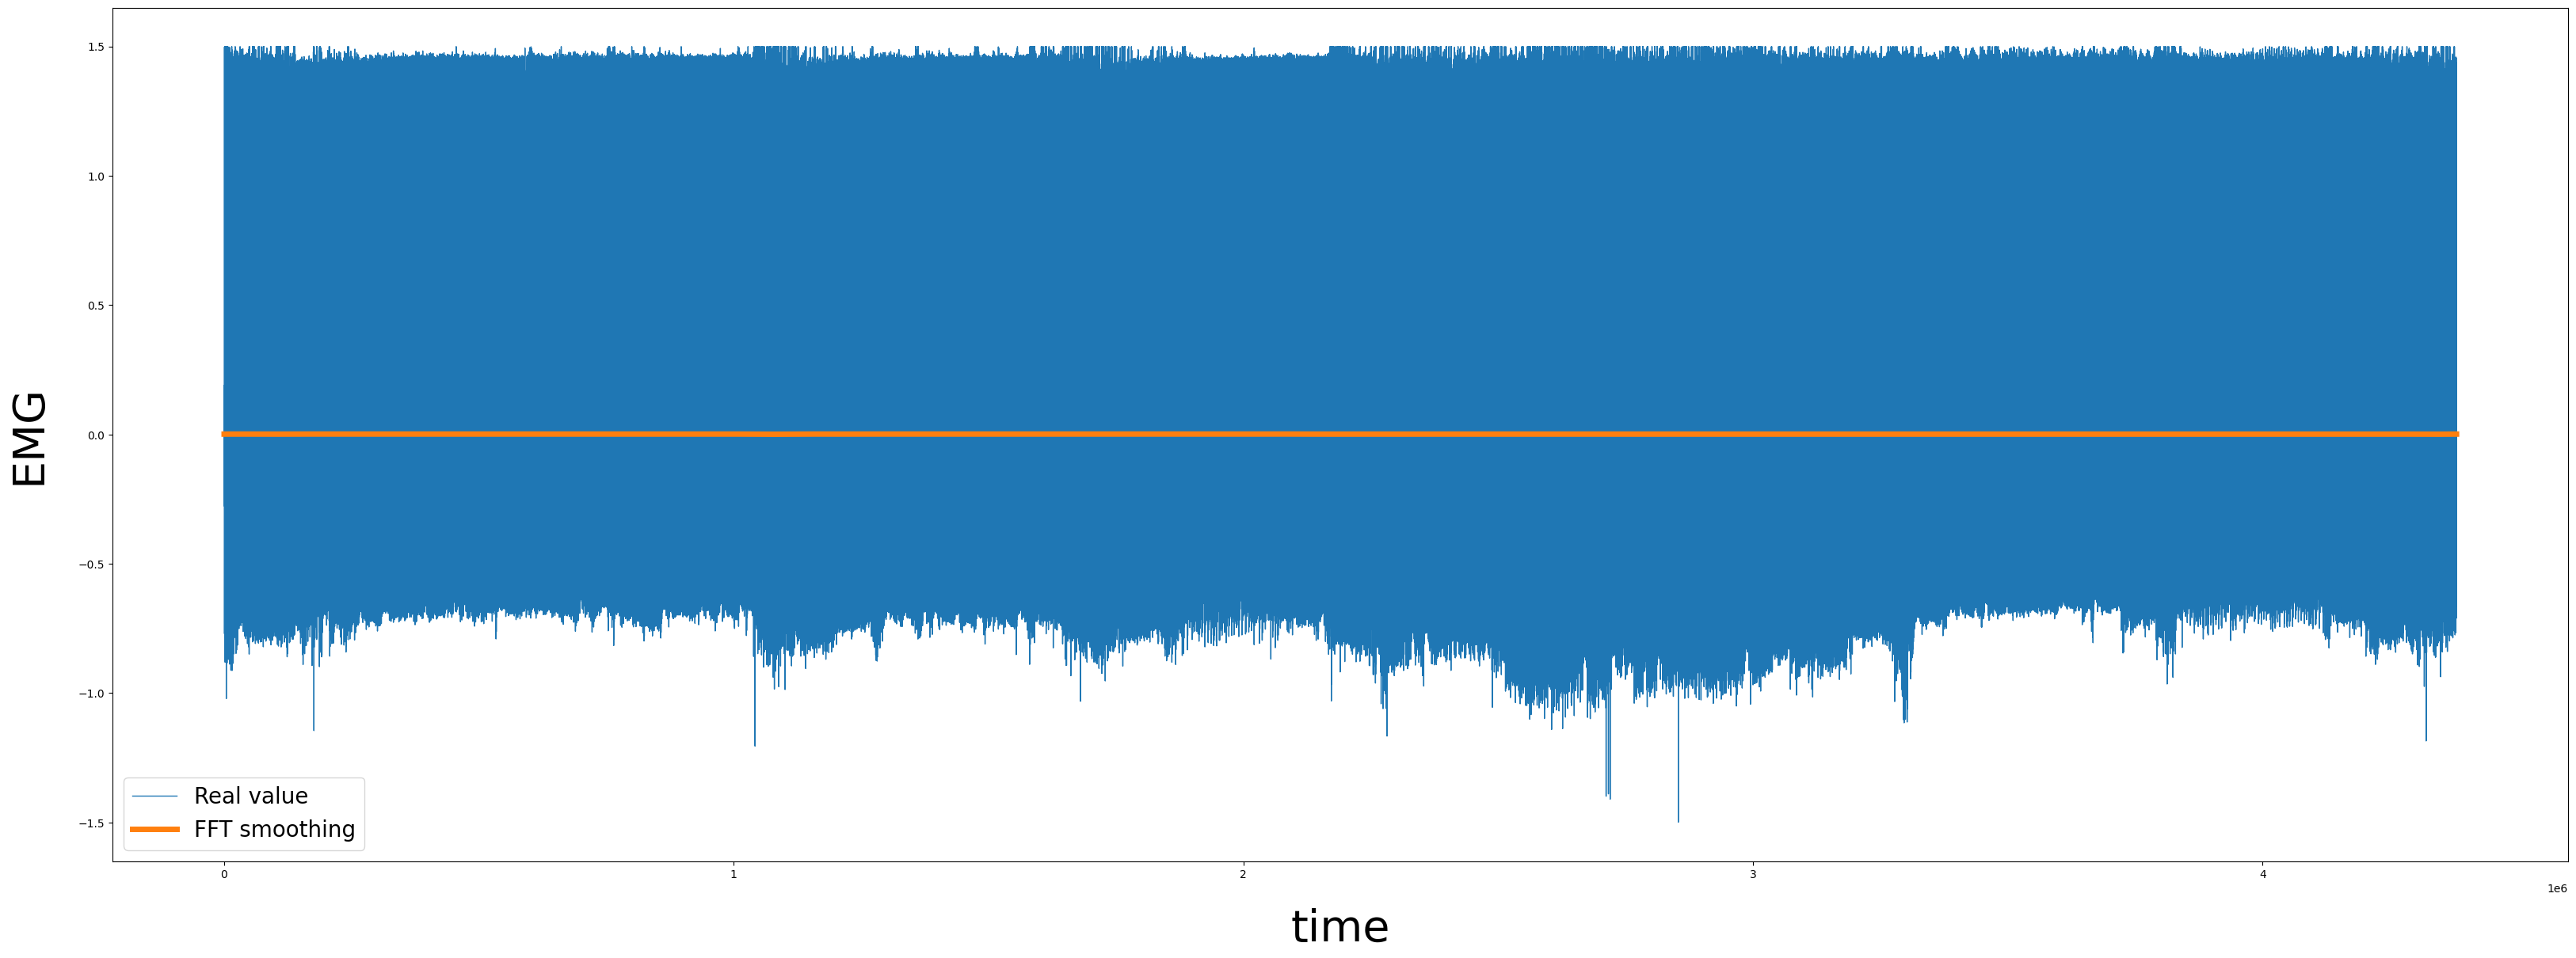

In [28]:
fig = plt.figure(figsize=(40,14))
plt.xlabel('time',fontsize=40, labelpad=25)
plt.ylabel('EMG',fontsize=40, labelpad=25)
plt.plot(sample_df["ECG"], linewidth=1)
plt.plot(teste, linewidth=5)
plt.legend(['Real value','FFT smoothing'], prop={'size': 20})
plt.title('',fontsize=40, pad=30)

plt.show()

In [29]:
sample_corr_df  = sample_df.corr("pearson")

sample_corr_df

,ECG,EMG,EDA,Temp,Resp,label_id
ECG,1.000000,-0.038543,-0.000210,-0.000223,-0.005208,0.000061
EMG,-0.038543,1.000000,-0.021898,-0.006276,-0.000312,0.003988
EDA,-0.000210,-0.021898,1.000000,-0.213464,-0.003151,-0.186922
Temp,-0.000223,-0.006276,-0.213464,1.000000,0.001937,0.346217
Resp,-0.005208,-0.000312,-0.003151,0.001937,1.000000,0.000427
label_id,0.000061,0.003988,-0.186922,0.346217,0.000427,1.000000


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


<AxesSubplot:>

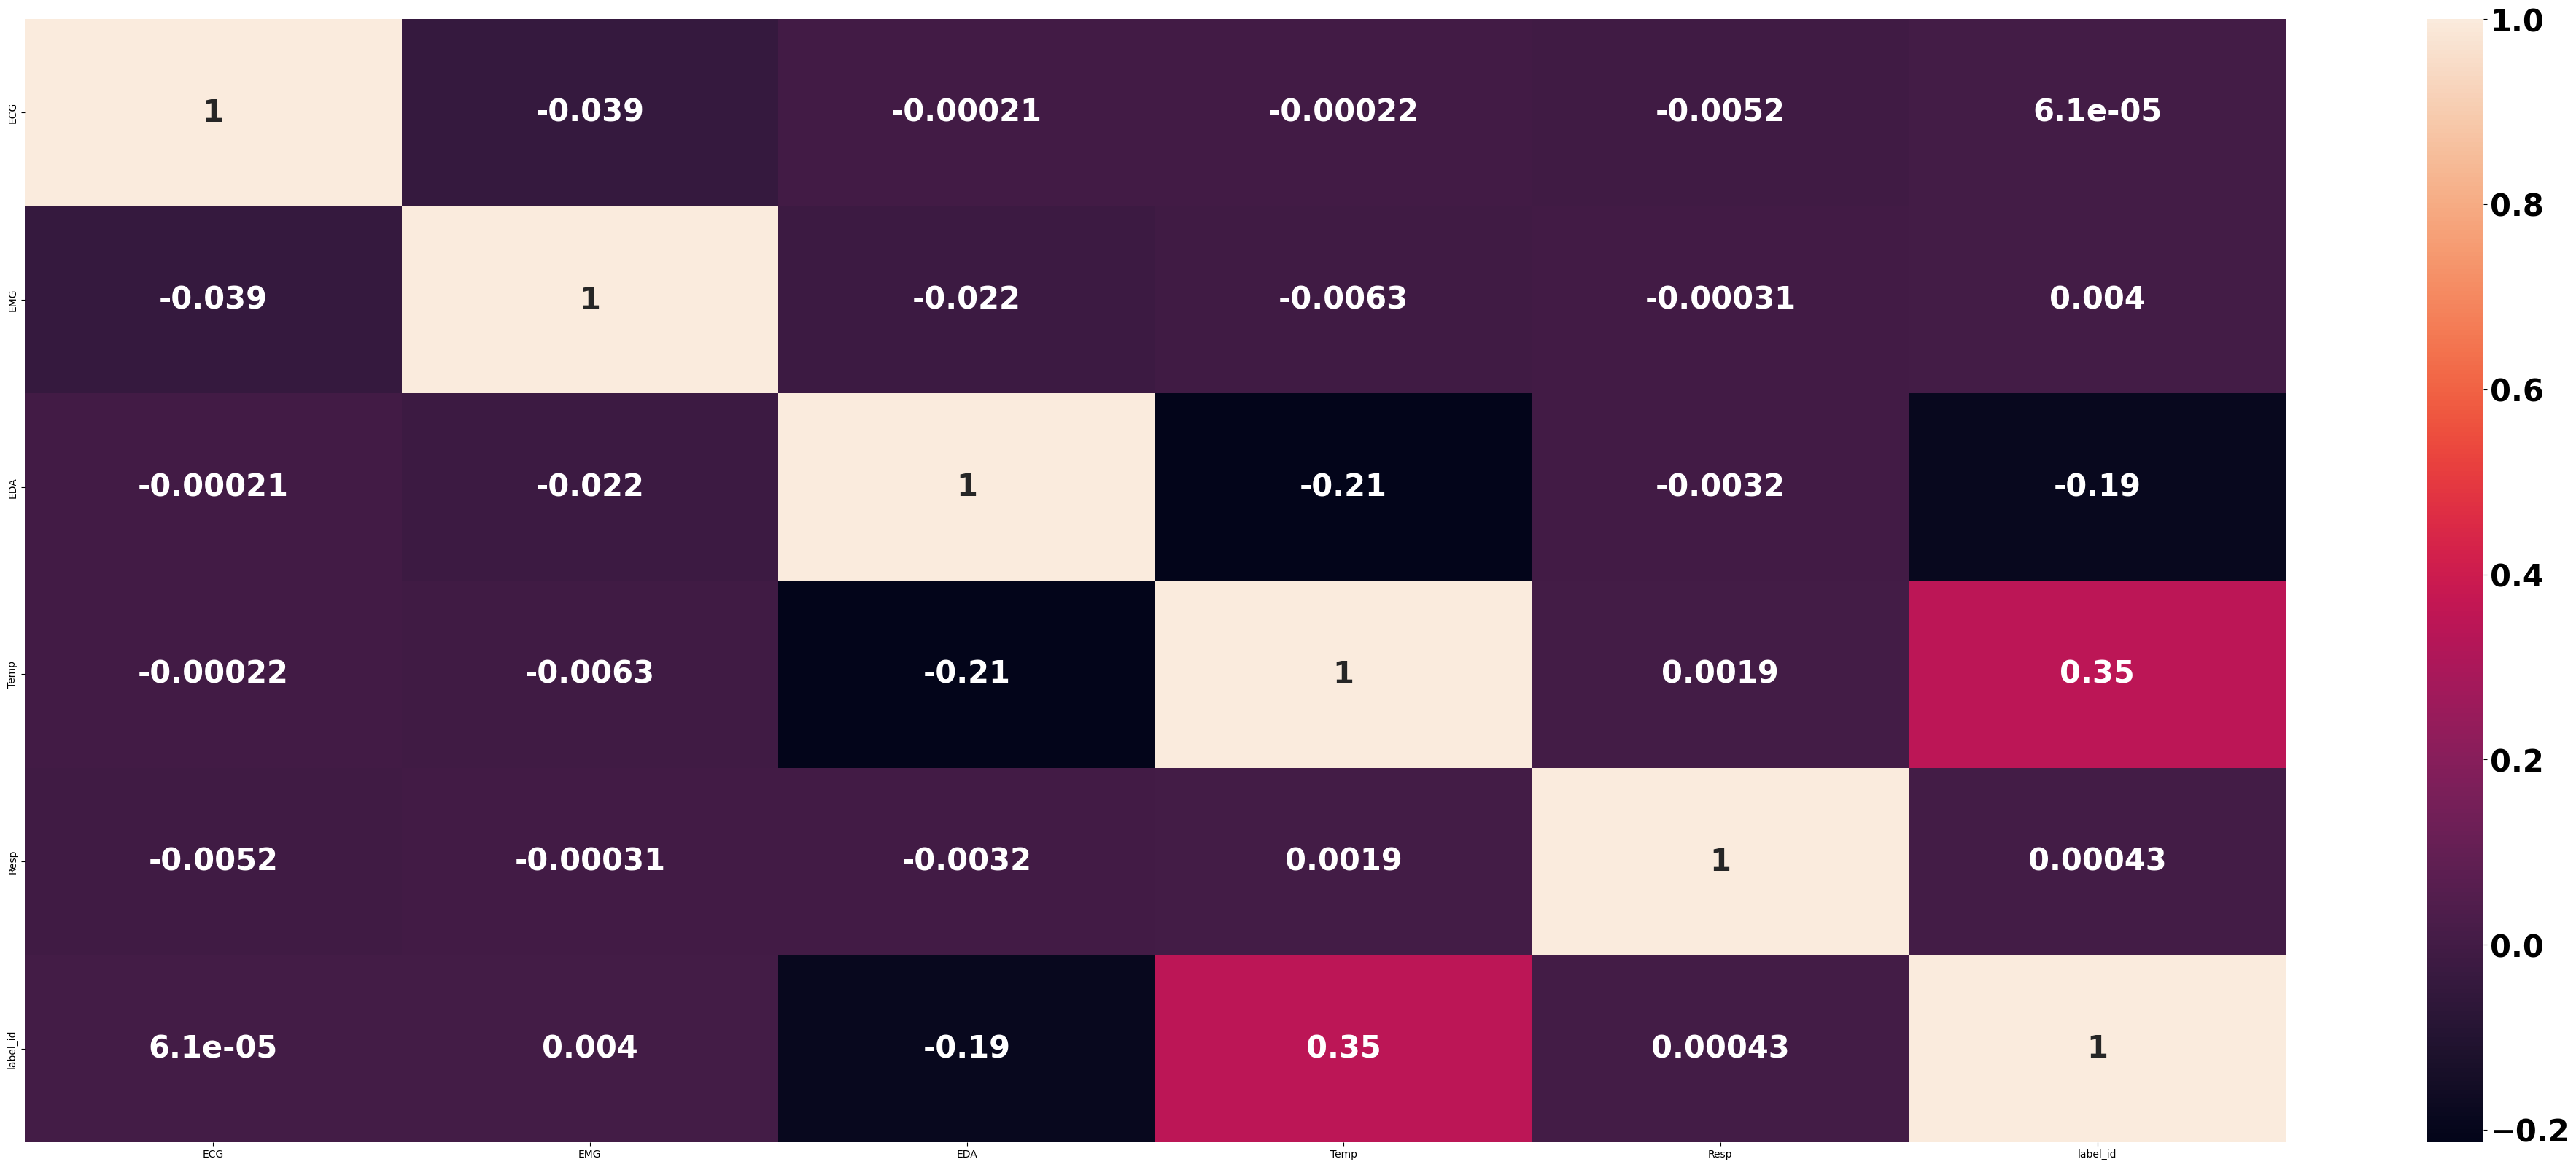

In [30]:
fig,ax_corr = plt.subplots(1, 1, figsize=(50,20))

font = {'family' : 'normal',
            'weight' : 'bold',
            'size'   : 30}
plt.rc("font",**font)

sn.heatmap(sample_corr_df, annot=True, ax=ax_corr)

# Cleaning Data

In [31]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [32]:
pacient_state_list  = [[state, pacient_state[state]] for state in pacient_state]

enc = OneHotEncoder(handle_unknown="ignore")
enc.fit(pacient_state_list)

enc.categories_

[array([0, 1, 2, 3, 4, 5], dtype=object),
 array(['Amusement', 'Baseline', 'Error/Not Labeled', 'Meditation',
        'Not Defined/Transient', 'Stress'], dtype=object)]

In [33]:
win_size = 60 # represent 1 minute

def simple_rolling_z_score(x, window):
    r = x.rolling(window=window)
    m = r.mean()
    s = r.std(ddof=0)
    z = (x-m)/s
    return z

In [34]:
def rolling_z_score(df, win_size):

    copy_df = df.copy()

    for i in range(len(df) - win_size + 1):
        slicer = slice(i, win_size + i)
        mean = df[slicer].mean()
        std = df[slicer].std(ddof=0)

        copy_df[slicer] = (df[slicer] - mean) / std

    return copy_df


In [35]:
clean_chest_data = []

for data_df in input_chest_data:

    # resampling data choosing one point each 700 points

    resample_data_df = data_df[::700]

    # apllying one hot encoder

    # label = resample_data_df.pop("label").to_numpy()
    # label_id = resample_data_df.pop("label_id").to_numpy()
    resample_data_df.pop("label")

    # label_list = [[label_id[i], label[i]] for i in range(len(resample_data_df))]

    # target = enc.transform(label_list).toarray()

    target = resample_data_df.pop("label_id").to_numpy()

    # applying rolling score-z

    subject_label = resample_data_df.pop("subject").to_numpy()[0]

    nodmalized_data_df = rolling_z_score(
        resample_data_df,
        win_size
    )

    # tuple = (normalized_data_df, target, subject_label)

    clean_chest_data.append((nodmalized_data_df, target, subject_label))



In [36]:
sample = clean_chest_data[0]

In [37]:
sample

(              ECG       EMG       EDA      Temp      Resp
 1       -1.141354  1.010902 -3.086350  0.761450  0.014113
 701     -0.180240 -0.664806 -3.502281  0.003950  0.354657
 1401    -0.274072  0.947775 -3.141712  0.444722  0.807513
 2101     0.051459  0.534775 -1.374533  0.391319 -0.447787
 2801     0.203342  0.187253 -1.059586 -0.591657 -0.676844
 ...           ...       ...       ...       ...       ...
 4377101  3.688604  0.490229 -0.347143  1.430297  1.046071
 4377801 -0.220608 -1.806449 -0.304009  1.203311 -0.949383
 4378501 -0.370882  1.531488 -0.285798  0.852218 -0.178434
 4379201 -0.321395 -0.591647 -0.291549  0.233314  0.324026
 4379901 -0.474520  0.877932 -0.326055  0.686877 -0.914863
 
 [6258 rows x 5 columns],
 array([0, 0, 0, ..., 0, 0, 0]),
 'S5')

In [38]:
sample_data_df = sample[0]

In [39]:
sample_data_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ECG,6258.0,-0.008513,1.004793,-6.563428,-0.307366,-0.116652,0.119997,7.582440
EMG,6258.0,0.000242,1.035429,-6.152012,-0.568847,0.044271,0.590430,5.852986
EDA,6258.0,0.345882,1.400994,-4.466730,-0.764205,0.376400,1.631442,5.557065
Temp,6258.0,-0.156492,1.214242,-4.190432,-0.991951,-0.072184,0.701792,4.071720
Resp,6258.0,-0.003516,1.021687,-5.952565,-0.662984,-0.139023,0.654771,4.669473


In [40]:
sample_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6258 entries, 1 to 4379901
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ECG     6258 non-null   float64
 1   EMG     6258 non-null   float64
 2   EDA     6258 non-null   float64
 3   Temp    6258 non-null   float32
 4   Resp    6258 non-null   float64
dtypes: float32(1), float64(4)
memory usage: 268.9 KB


In [41]:
sample_target = sample[1]

In [42]:
sample_target

array([0, 0, 0, ..., 0, 0, 0])

In [43]:
unique_values = np.unique(sample_target, axis=0)

In [44]:
unique_values

array([0, 1, 2, 3, 4, 5])

In [45]:
# decode_unique_values = enc.inverse_transform(unique_values)

In [46]:
# decode_unique_values

# Windowing

In [47]:
def get_most_repeted_element(np_array):
    (unique, counts) = np.unique(np_array, return_counts=True, axis=0)
    most_repeted_element_index = np.where(counts == max(counts))
    return unique[most_repeted_element_index[0][0]]

In [48]:
def get_window_feature_and_related_target(df, np_array, win_size):
    windows_list = []
    for i in range(len(df) - win_size + 1):
        slicer = slice(i, win_size + i)
        windows_list.append((df[slicer].to_numpy(), get_most_repeted_element(np_array[i:win_size+i])))
    return np.array(windows_list)

In [49]:
sample_window_target = get_window_feature_and_related_target(sample_data_df, sample_target, win_size)

/var/folders/7_/2_zd275d5mv2_2m6k8c0cqmc0000gq/T/ipykernel_32496/1102965131.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(windows_list)


In [50]:
sample_window_target[0][0]

array([[-1.14135380e+00,  1.01090174e+00, -3.08635004e+00,
         7.61449635e-01,  1.41128001e-02],
       [-1.80240021e-01, -6.64805531e-01, -3.50228098e+00,
         3.95013951e-03,  3.54657173e-01],
       [-2.74072260e-01,  9.47774799e-01, -3.14171184e+00,
         4.44722414e-01,  8.07512662e-01],
       [ 5.14586772e-02,  5.34774851e-01, -1.37453252e+00,
         3.91319096e-01, -4.47786975e-01],
       [ 2.03341985e-01,  1.87253041e-01, -1.05958642e+00,
        -5.91656923e-01, -6.76844055e-01],
       [ 5.20270293e-01,  2.42621583e-01, -1.92588078e+00,
         4.79015678e-01,  1.38846882e-01],
       [-1.01082822e+00, -2.14383455e-01, -2.54394250e+00,
        -8.25006723e-01, -5.15933413e-02],
       [ 1.79039367e-02, -1.71774414e-01, -2.60422474e+00,
         5.55276334e-01, -3.85099014e-01],
       [-3.41454189e-01,  8.86010104e-01, -6.30514547e-01,
        -1.45706904e+00,  6.88676762e-01],
       [-3.26528244e+00, -2.38711880e-02,  4.81683492e-01,
        -6.36333823e-01

In [51]:
sample_window_target[0][1]

0

In [52]:
sample_window_target[1]

array([array([[-1.80240021e-01, -6.64805531e-01, -3.50228098e+00,
         3.95013951e-03,  3.54657173e-01],
       [-2.74072260e-01,  9.47774799e-01, -3.14171184e+00,
         4.44722414e-01,  8.07512662e-01],
       [ 5.14586772e-02,  5.34774851e-01, -1.37453252e+00,
         3.91319096e-01, -4.47786975e-01],
       [ 2.03341985e-01,  1.87253041e-01, -1.05958642e+00,
        -5.91656923e-01, -6.76844055e-01],
       [ 5.20270293e-01,  2.42621583e-01, -1.92588078e+00,
         4.79015678e-01,  1.38846882e-01],
       [-1.01082822e+00, -2.14383455e-01, -2.54394250e+00,
        -8.25006723e-01, -5.15933413e-02],
       [ 1.79039367e-02, -1.71774414e-01, -2.60422474e+00,
         5.55276334e-01, -3.85099014e-01],
       [-3.41454189e-01,  8.86010104e-01, -6.30514547e-01,
        -1.45706904e+00,  6.88676762e-01],
       [-3.26528244e+00, -2.38711880e-02,  4.81683492e-01,
        -6.36333823e-01, -1.97923434e-01],
       [ 1.77439039e-01, -4.28558251e-01, -1.25683631e-01,
         9.59694

In [53]:
model_data = []
model_features = []
model_targets = []
subjects_list = []

for data in clean_chest_data:

    data_df = data[0]
    data_target = data[1]
    data_subject = data[2]

    window_target = get_window_feature_and_related_target(data_df, data_target, win_size)

    model_data.append(window_target)
    model_features.append(window_target[:,0])
    model_targets.append(window_target[:,1])
    subjects_list.append(data_subject)
    

/var/folders/7_/2_zd275d5mv2_2m6k8c0cqmc0000gq/T/ipykernel_32496/1102965131.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(windows_list)


In [54]:
# model_data[subject][specific window_feature_target][feature or target]

len(model_data)

15

In [55]:
# model_features[all windows_feature of a subject][specific feature]
# model_targets[all windows_target of a subject][specific target]

(model_data[0][0][0] == model_features[0][0]).all()

True

In [56]:
(model_data[0][0][1] == model_targets[0][0]).all()

True

In [57]:
(sample_window_target[0][0] == model_features[0][0]).all()

True

In [58]:
(sample_window_target[0][1] == model_data[0][0][1]).all()

True

In [59]:
# Number of windows_features of the first pacient

len(model_features[0])

6199

In [60]:
# Number of targets of the each window

len(model_targets[0])

6199

In [61]:
# Size of a window

len(model_features[0][0])

60

In [62]:
print(f'For the window feature: \n\n {model_features[0][0]}\n\n')
print(f'With the zize: {len(model_features[0][0])}\n\n')
print(f'We have the following encoded mental state: \n\n {model_targets[0][0]}')

For the window feature: 

 [[-1.14135380e+00  1.01090174e+00 -3.08635004e+00  7.61449635e-01
   1.41128001e-02]
 [-1.80240021e-01 -6.64805531e-01 -3.50228098e+00  3.95013951e-03
   3.54657173e-01]
 [-2.74072260e-01  9.47774799e-01 -3.14171184e+00  4.44722414e-01
   8.07512662e-01]
 [ 5.14586772e-02  5.34774851e-01 -1.37453252e+00  3.91319096e-01
  -4.47786975e-01]
 [ 2.03341985e-01  1.87253041e-01 -1.05958642e+00 -5.91656923e-01
  -6.76844055e-01]
 [ 5.20270293e-01  2.42621583e-01 -1.92588078e+00  4.79015678e-01
   1.38846882e-01]
 [-1.01082822e+00 -2.14383455e-01 -2.54394250e+00 -8.25006723e-01
  -5.15933413e-02]
 [ 1.79039367e-02 -1.71774414e-01 -2.60422474e+00  5.55276334e-01
  -3.85099014e-01]
 [-3.41454189e-01  8.86010104e-01 -6.30514547e-01 -1.45706904e+00
   6.88676762e-01]
 [-3.26528244e+00 -2.38711880e-02  4.81683492e-01 -6.36333823e-01
  -1.97923434e-01]
 [ 1.77439039e-01 -4.28558251e-01 -1.25683631e-01  9.59694013e-02
  -8.29354685e-01]
 [-1.83612742e-01  1.65654157e-01 -5.6

# Model

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, LeakyReLU, Activation, GRU, GaussianNoise, Flatten
from tensorflow.keras.regularizers import L1
from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow import convert_to_tensor

import datetime

In [64]:
# In order to validate the model, we are gonna drop the data of one 

model_features_validation = model_features.pop()
model_targets_validation = model_targets.pop()
print(f'Validation Subject: {subjects_list.pop()}')
print(f'Validation Feature Shape and Type: {model_features_validation.shape}, {type(model_features_validation)}')
print(f'Validation Target Shape and Type: {model_targets_validation.shape}, {type(model_targets_validation)}')

Validation Subject: S15
Validation Feature Shape and Type: (5193,), <class 'numpy.ndarray'>
Validation Target Shape and Type: (5193,), <class 'numpy.ndarray'>


In [65]:
with open("processed_data/validation_data.pickle", "wb") as f:
    pickle.dump({
        "features": model_features_validation,
        "targets": model_targets_validation,
    }, f)

In [66]:
model_targets_validation

array([0, 0, 0, ..., 0, 0, 0], dtype=object)

In [67]:
model_features[0].shape

(6199,)

In [68]:
model_targets[0].shape

(6199,)

In [69]:
# Group data of all subjects in one array

features = model_features[0]
targets = model_targets[0]

for i in range(1, len(subjects_list)):
    features = np.concatenate((features, model_features[i]), axis=0)
    targets = np.concatenate((targets, model_targets[i]), axis=0)

In [70]:
# features: has all windows with size of 60

features.shape, features[0].shape

((80790,), (60, 5))

In [71]:
# targets: has all targets for each window with size of 60

targets.shape, targets[0].shape

((80790,), ())

In [72]:
np.unique(targets)

array([0, 1, 2, 3, 4, 5], dtype=object)

In [73]:
# converting to Tensors

features_tensor = convert_to_tensor(
    np.array(
        [convert_to_tensor(data) for data in features]
    )
)

features_tensor.shape

2021-12-26 22:48:54.191720: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorShape([80790, 60, 5])

In [74]:
targets

array([0, 0, 0, ..., 0, 0, 0], dtype=object)

In [75]:
targets.reshape(len(targets),-1)

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=object)

In [76]:
targets_tensor = convert_to_tensor(targets.reshape(len(targets),-1), dtype="int64")

targets_tensor.shape


TensorShape([80790, 1])

In [77]:
targets_tensor

<tf.Tensor: shape=(80790, 1), dtype=int64, numpy=
array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])>

In [78]:
weights = compute_class_weight(class_weight = "balanced", classes = np.unique(targets), y = targets)
weights = {i : weights[i] for i in range(len(weights))}

In [79]:
weights

{0: 0.36658408428847566,
 1: 0.8200365408038977,
 2: 1.4531620979926614,
 3: 2.5949123145114665,
 4: 1.2258739985433358,
 5: 6.120454545454545}

In [80]:
with open("processed_data/trainning_data.pickle", "wb") as f:
    pickle.dump({
        "features": features_tensor,
        "targets": targets_tensor,
        "weights": weights
    }, f)

In [81]:
targets.shape

(80790,)

In [82]:
np.unique(targets)

array([0, 1, 2, 3, 4, 5], dtype=object)

In [83]:
def lstm(model = None):
    model.add(GaussianNoise(0.1))
    model.add(LSTM(128, input_shape=(win_size, 5), return_sequences=True))
    model.add(LeakyReLU(alpha=0.5))
    model.add(Dropout(0.3))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(6))

def gru(model = None):
    model.add(GRU(128, input_shape=(win_size, 5), return_sequences=True))
    model.add(LeakyReLU(alpha=0.5))
    model.add(GaussianNoise(0.5))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(6, activity_regularizer = L1(0.0001)))


In [84]:
# duas lstm uma dropout e uma dense
# testar uma GRU (trocar todas as LSTM por elas)


def create_model(has_activator, last_activation_layer, hidden_layer_type, optimizer):

    model = Sequential()
    hidden_layer_type(model)
    if has_activator:
        model.add(Activation(last_activation_layer))
    model.build()

    model.summary()

    model.compile(
        loss = "sparse_categorical_crossentropy",
        optimizer = optimizer, #nadam or rmstrop
        metrics = ["accuracy"]
    )

    return model


In [85]:
models_to_test = {
    # "softmax_lstm_adam": {
    #     "has_activator": True,
    #     "activator_layer": "softmax",
    #     "color_plot": "blue",
    #     "layers": lstm,
    #     "optimizer": "adam",
    #     "callbacks": [
    #         EarlyStopping(monitor='val_accuracy', patience=20, mode='min'),
    #         TensorBoard(log_dir = "logs/softmax/lstm/adam/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), write_graph=True, histogram_freq=5)
    #     ]
    # },
    # "softmax_lstm_nadam": {
    #     "has_activator": True,
    #     "activator_layer": "softmax",
    #     "color_plot": "red",
    #     "layers": lstm,
    #     "optimizer": "nadam",
    #     "callbacks": [
    #         EarlyStopping(monitor='val_accuracy', patience=20, mode='min'),
    #         TensorBoard(log_dir = "logs/softmax/lstm/nadam/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), write_graph=True, histogram_freq=5)
    #     ]
    # },
    # "softmax_lstm_rmsprop": {
    #     "has_activator": True,
    #     "activator_layer": "softmax",
    #     "color_plot": "green",
    #     "layers": lstm,
    #     "optimizer": "rmsprop",
    #     "callbacks": [
    #         EarlyStopping(monitor='val_accuracy', patience=20, mode='min'),
    #         TensorBoard(log_dir = "logs/softmax/lstm/rmsprop/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), write_graph=True, histogram_freq=5)
    #     ]
    # }
    "softmax_gru_adam": {
        "has_activator": True,
        "activator_layer": "softmax",
        "color_plot": "yellow",
        "layers": gru,
        "optimizer": "adam",
        "callbacks": [
            # EarlyStopping(monitor='val_accuracy', patience=20, mode='min'),
            TensorBoard(log_dir = "logs/softmax/gru/adam/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), write_graph=True, histogram_freq=5)
        ]
    },
    "softmax_gru_nadam": {
        "has_activator": True,
        "activator_layer": "softmax",
        "color_plot": "magenta",
        "layers": gru,
        "optimizer": "nadam",
        "callbacks": [
            # EarlyStopping(monitor='val_accuracy', patience=20, mode='min'),
            TensorBoard(log_dir = "logs/softmax/gru/nadam/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), write_graph=True, histogram_freq=5)
        ]
    },
    "softmax_gru_rmsprop": {
        "has_activator": True,
        "activator_layer": "softmax",
        "color_plot": "cyan",
        "layers": gru,
        "optimizer": "rmsprop",
        "callbacks": [
            # EarlyStopping(monitor='val_accuracy', patience=20, mode='min'),
            TensorBoard(log_dir = "logs/softmax/gru/rmsprop/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), write_graph=True, histogram_freq=5)
        ]
    }   
}

2021-12-26 22:48:57.296071: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-26 22:48:57.296086: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-26 22:48:57.297327: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-26 22:48:57.298062: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-26 22:48:57.298070: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-26 22:48:57.298202: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-26 22:48:57.298261: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-26 22:48:57.298267: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-26 22:48:57.298566: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session 

In [86]:
models_to_test

{'softmax_gru_adam': {'has_activator': True,
  'activator_layer': 'softmax',
  'color_plot': 'yellow',
  'layers': <function __main__.gru(model=None)>,
  'optimizer': 'adam',
  'callbacks': [<keras.callbacks.TensorBoard at 0x16ff876d0>]},
 'softmax_gru_nadam': {'has_activator': True,
  'activator_layer': 'softmax',
  'color_plot': 'magenta',
  'layers': <function __main__.gru(model=None)>,
  'optimizer': 'nadam',
  'callbacks': [<keras.callbacks.TensorBoard at 0x1969a82b0>]},
 'softmax_gru_rmsprop': {'has_activator': True,
  'activator_layer': 'softmax',
  'color_plot': 'cyan',
  'layers': <function __main__.gru(model=None)>,
  'optimizer': 'rmsprop',
  'callbacks': [<keras.callbacks.TensorBoard at 0x1969a8250>]}}

In [87]:
for model_name in models_to_test:

    has_activator = models_to_test[model_name]["has_activator"]
    activation_layer = models_to_test[model_name]["activator_layer"]
    hidden_layer = models_to_test[model_name]["layers"]
    optimizer = models_to_test[model_name]["optimizer"]
    
    

    model = create_model(has_activator, activation_layer, hidden_layer, optimizer)
    history = model.fit(
        x=features_tensor,
        y=targets_tensor,
        validation_split=0.4,
        epochs=100,
        shuffle=False,
        class_weight=weights,
        callbacks=models_to_test[model_name]["callbacks"]
    )

    model.save(f"models/stress_detection_{model_name}")

    models_to_test[model_name]["history"] = history
    models_to_test[model_name]["model"] = model


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 60, 128)           51840     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 60, 128)           0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 60, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 7680)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 46086     
_________________________________________________________________
activation (Activation)      (None, 6)                 0

2021-12-26 22:48:57.757953: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
   2/1515 [..............................] - ETA: 2:38 - loss: 0.6943 - accuracy: 0.2188 

2021-12-26 22:48:59.350471: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-26 22:48:59.350489: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-26 22:48:59.391225: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-26 22:48:59.426790: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-26 22:48:59.496208: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/softmax/gru/adam/fit/20211226-224857/train/plugins/profile/2021_12_26_22_48_59

2021-12-26 22:48:59.529172: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/softmax/gru/adam/fit/20211226-224857/train/plugins/profile/2021_12_26_22_48_59/C02D602YMD6Q.trace.json.gz
2021-12-26 22:48:59.546222: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log

1515/1515 [==============================] - 41s 26ms/step - loss: 2.6410 - accuracy: 0.1966 - val_loss: 2.1938 - val_accuracy: 0.1984
Epoch 2/100
1515/1515 [==============================] - 38s 25ms/step - loss: 2.6359 - accuracy: 0.1836 - val_loss: 2.4034 - val_accuracy: 0.1884
Epoch 3/100
1515/1515 [==============================] - 38s 25ms/step - loss: 2.7159 - accuracy: 0.1890 - val_loss: 2.2928 - val_accuracy: 0.1921
Epoch 4/100
1515/1515 [==============================] - 38s 25ms/step - loss: 2.7505 - accuracy: 0.1839 - val_loss: 2.0816 - val_accuracy: 0.1924
Epoch 5/100
1515/1515 [==============================] - 39s 26ms/step - loss: 2.7444 - accuracy: 0.1901 - val_loss: 2.1765 - val_accuracy: 0.2031
Epoch 6/100
1515/1515 [==============================] - 38s 25ms/step - loss: 2.7431 - accuracy: 0.1967 - val_loss: 2.0563 - val_accuracy: 0.2541
Epoch 7/100
1515/1515 [==============================] - 39s 25ms/step - loss: 2.5866 - accuracy: 0.2325 - val_loss: 1.9202 - val_

2021-12-26 23:57:01.404577: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/stress_detection_softmax_gru_adam/assets


INFO:tensorflow:Assets written to: models/stress_detection_softmax_gru_adam/assets


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 60, 128)           51840     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 60, 128)           0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 60, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7680)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 46086     
_________________________________________________________________
activation_1 (Activation)    (None, 6)                

2021-12-26 23:57:05.154362: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-26 23:57:05.154376: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-26 23:57:05.256535: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-26 23:57:05.285116: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-26 23:57:05.351338: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/softmax/gru/nadam/fit/20211226-224857/train/plugins/profile/2021_12_26_23_57_05



   8/1515 [..............................] - ETA: 1:39 - loss: 0.6486 - accuracy: 0.4102

2021-12-26 23:57:05.375022: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/softmax/gru/nadam/fit/20211226-224857/train/plugins/profile/2021_12_26_23_57_05/C02D602YMD6Q.trace.json.gz
2021-12-26 23:57:05.392594: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/softmax/gru/nadam/fit/20211226-224857/train/plugins/profile/2021_12_26_23_57_05

2021-12-26 23:57:05.400970: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/softmax/gru/nadam/fit/20211226-224857/train/plugins/profile/2021_12_26_23_57_05/C02D602YMD6Q.memory_profile.json.gz
2021-12-26 23:57:05.404800: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: logs/softmax/gru/nadam/fit/20211226-224857/train/plugins/profile/2021_12_26_23_57_05
Dumped tool data for xplane.pb to logs/softmax/gru/nadam/fit/20211226-224857/train/plugins/profile/2021_

1515/1515 [==============================] - 42s 27ms/step - loss: 2.2623 - accuracy: 0.2916 - val_loss: 3.2193 - val_accuracy: 0.1880
Epoch 2/100
1515/1515 [==============================] - 41s 27ms/step - loss: 2.4280 - accuracy: 0.2562 - val_loss: 2.9441 - val_accuracy: 0.1905
Epoch 3/100
1515/1515 [==============================] - 41s 27ms/step - loss: 2.4688 - accuracy: 0.2792 - val_loss: 2.3511 - val_accuracy: 0.2969
Epoch 4/100
1515/1515 [==============================] - 41s 27ms/step - loss: 2.3950 - accuracy: 0.3063 - val_loss: 2.2775 - val_accuracy: 0.3033
Epoch 5/100
1515/1515 [==============================] - 41s 27ms/step - loss: 2.3575 - accuracy: 0.3300 - val_loss: 2.4477 - val_accuracy: 0.3096
Epoch 6/100
1515/1515 [==============================] - 41s 27ms/step - loss: 2.3017 - accuracy: 0.3405 - val_loss: 2.5170 - val_accuracy: 0.3228
Epoch 7/100
1515/1515 [==============================] - 40s 27ms/step - loss: 2.1560 - accuracy: 0.3712 - val_loss: 2.7829 - val_

INFO:tensorflow:Assets written to: models/stress_detection_softmax_gru_nadam/assets


INFO:tensorflow:Assets written to: models/stress_detection_softmax_gru_nadam/assets


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 60, 128)           51840     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 60, 128)           0         
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 60, 128)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 7680)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 46086     
_________________________________________________________________
activation_2 (Activation)    (None, 6)                

2021-12-27 01:05:50.562984: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-27 01:05:50.562999: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-27 01:05:50.663842: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-27 01:05:50.693960: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-27 01:05:50.728961: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/softmax/gru/rmsprop/fit/20211226-224857/train/plugins/profile/2021_12_27_01_05_50

2021-12-27 01:05:50.750615: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/softmax/gru/rmsprop/fit/20211226-224857/train/plugins/profile/2021_12_27_01_05_50/C02D602YMD6Q.trace.json.gz


   8/1515 [..............................] - ETA: 1:32 - loss: 0.4531 - accuracy: 0.6406

2021-12-27 01:05:50.767117: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/softmax/gru/rmsprop/fit/20211226-224857/train/plugins/profile/2021_12_27_01_05_50

2021-12-27 01:05:50.778594: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/softmax/gru/rmsprop/fit/20211226-224857/train/plugins/profile/2021_12_27_01_05_50/C02D602YMD6Q.memory_profile.json.gz
2021-12-27 01:05:50.782284: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: logs/softmax/gru/rmsprop/fit/20211226-224857/train/plugins/profile/2021_12_27_01_05_50
Dumped tool data for xplane.pb to logs/softmax/gru/rmsprop/fit/20211226-224857/train/plugins/profile/2021_12_27_01_05_50/C02D602YMD6Q.xplane.pb
Dumped tool data for overview_page.pb to logs/softmax/gru/rmsprop/fit/20211226-224857/train/plugins/profile/2021_12_27_01_05_50/C02D602YMD6Q.overview_page.pb
Dumped tool data for input_pipeline.pb to

1515/1515 [==============================] - 42s 27ms/step - loss: 1.7221 - accuracy: 0.5976 - val_loss: 3.8184 - val_accuracy: 0.3103
Epoch 2/100
1515/1515 [==============================] - 40s 27ms/step - loss: 1.5917 - accuracy: 0.6246 - val_loss: 3.7035 - val_accuracy: 0.2685
Epoch 3/100
1515/1515 [==============================] - 40s 27ms/step - loss: 1.4996 - accuracy: 0.6535 - val_loss: 4.1379 - val_accuracy: 0.2839
Epoch 4/100
1515/1515 [==============================] - 39s 26ms/step - loss: 1.4876 - accuracy: 0.6721 - val_loss: 3.4766 - val_accuracy: 0.2527
Epoch 5/100
1515/1515 [==============================] - 40s 26ms/step - loss: 1.3734 - accuracy: 0.6911 - val_loss: 3.3924 - val_accuracy: 0.2646
Epoch 6/100
1515/1515 [==============================] - 40s 26ms/step - loss: 1.3584 - accuracy: 0.6910 - val_loss: 3.5182 - val_accuracy: 0.3198
Epoch 7/100
1515/1515 [==============================] - 39s 26ms/step - loss: 1.1972 - accuracy: 0.7314 - val_loss: 3.6091 - val_

INFO:tensorflow:Assets written to: models/stress_detection_softmax_gru_rmsprop/assets


INFO:tensorflow:Assets written to: models/stress_detection_softmax_gru_rmsprop/assets


In [88]:
models_to_test

{'softmax_gru_adam': {'has_activator': True,
  'activator_layer': 'softmax',
  'color_plot': 'yellow',
  'layers': <function __main__.gru(model=None)>,
  'optimizer': 'adam',
  'callbacks': [<keras.callbacks.TensorBoard at 0x16ff876d0>],
  'history': <keras.callbacks.History at 0x170076fd0>,
  'model': <keras.engine.sequential.Sequential at 0x16fca37c0>},
 'softmax_gru_nadam': {'has_activator': True,
  'activator_layer': 'softmax',
  'color_plot': 'magenta',
  'layers': <function __main__.gru(model=None)>,
  'optimizer': 'nadam',
  'callbacks': [<keras.callbacks.TensorBoard at 0x1969a82b0>],
  'history': <keras.callbacks.History at 0x192568910>,
  'model': <keras.engine.sequential.Sequential at 0x16fb08a30>},
 'softmax_gru_rmsprop': {'has_activator': True,
  'activator_layer': 'softmax',
  'color_plot': 'cyan',
  'layers': <function __main__.gru(model=None)>,
  'optimizer': 'rmsprop',
  'callbacks': [<keras.callbacks.TensorBoard at 0x1969a8250>],
  'history': <keras.callbacks.History a

In [89]:
history.history

{'loss': [1.722098469734192,
  1.5916744470596313,
  1.499551773071289,
  1.4875587224960327,
  1.3734312057495117,
  1.3583773374557495,
  1.197228193283081,
  1.1484512090682983,
  0.9423669576644897,
  0.900198757648468,
  0.8722516894340515,
  0.8103692531585693,
  0.7694692015647888,
  0.6962624192237854,
  0.6548758149147034,
  0.5899374485015869,
  0.5205460786819458,
  0.4637482166290283,
  0.49003225564956665,
  0.4008510112762451,
  0.3551275432109833,
  0.31354108452796936,
  0.3040826618671417,
  0.2760792076587677,
  0.2686246931552887,
  0.24827128648757935,
  0.2556561827659607,
  0.20014363527297974,
  0.23093438148498535,
  0.2175447791814804,
  0.18852245807647705,
  0.20701953768730164,
  0.2029813826084137,
  0.14417129755020142,
  0.17296500504016876,
  0.15373222529888153,
  0.15379157662391663,
  0.1577853411436081,
  0.13276024162769318,
  0.15210947394371033,
  0.1142195537686348,
  0.15884438157081604,
  0.13855771720409393,
  0.12102823704481125,
  0.12467616

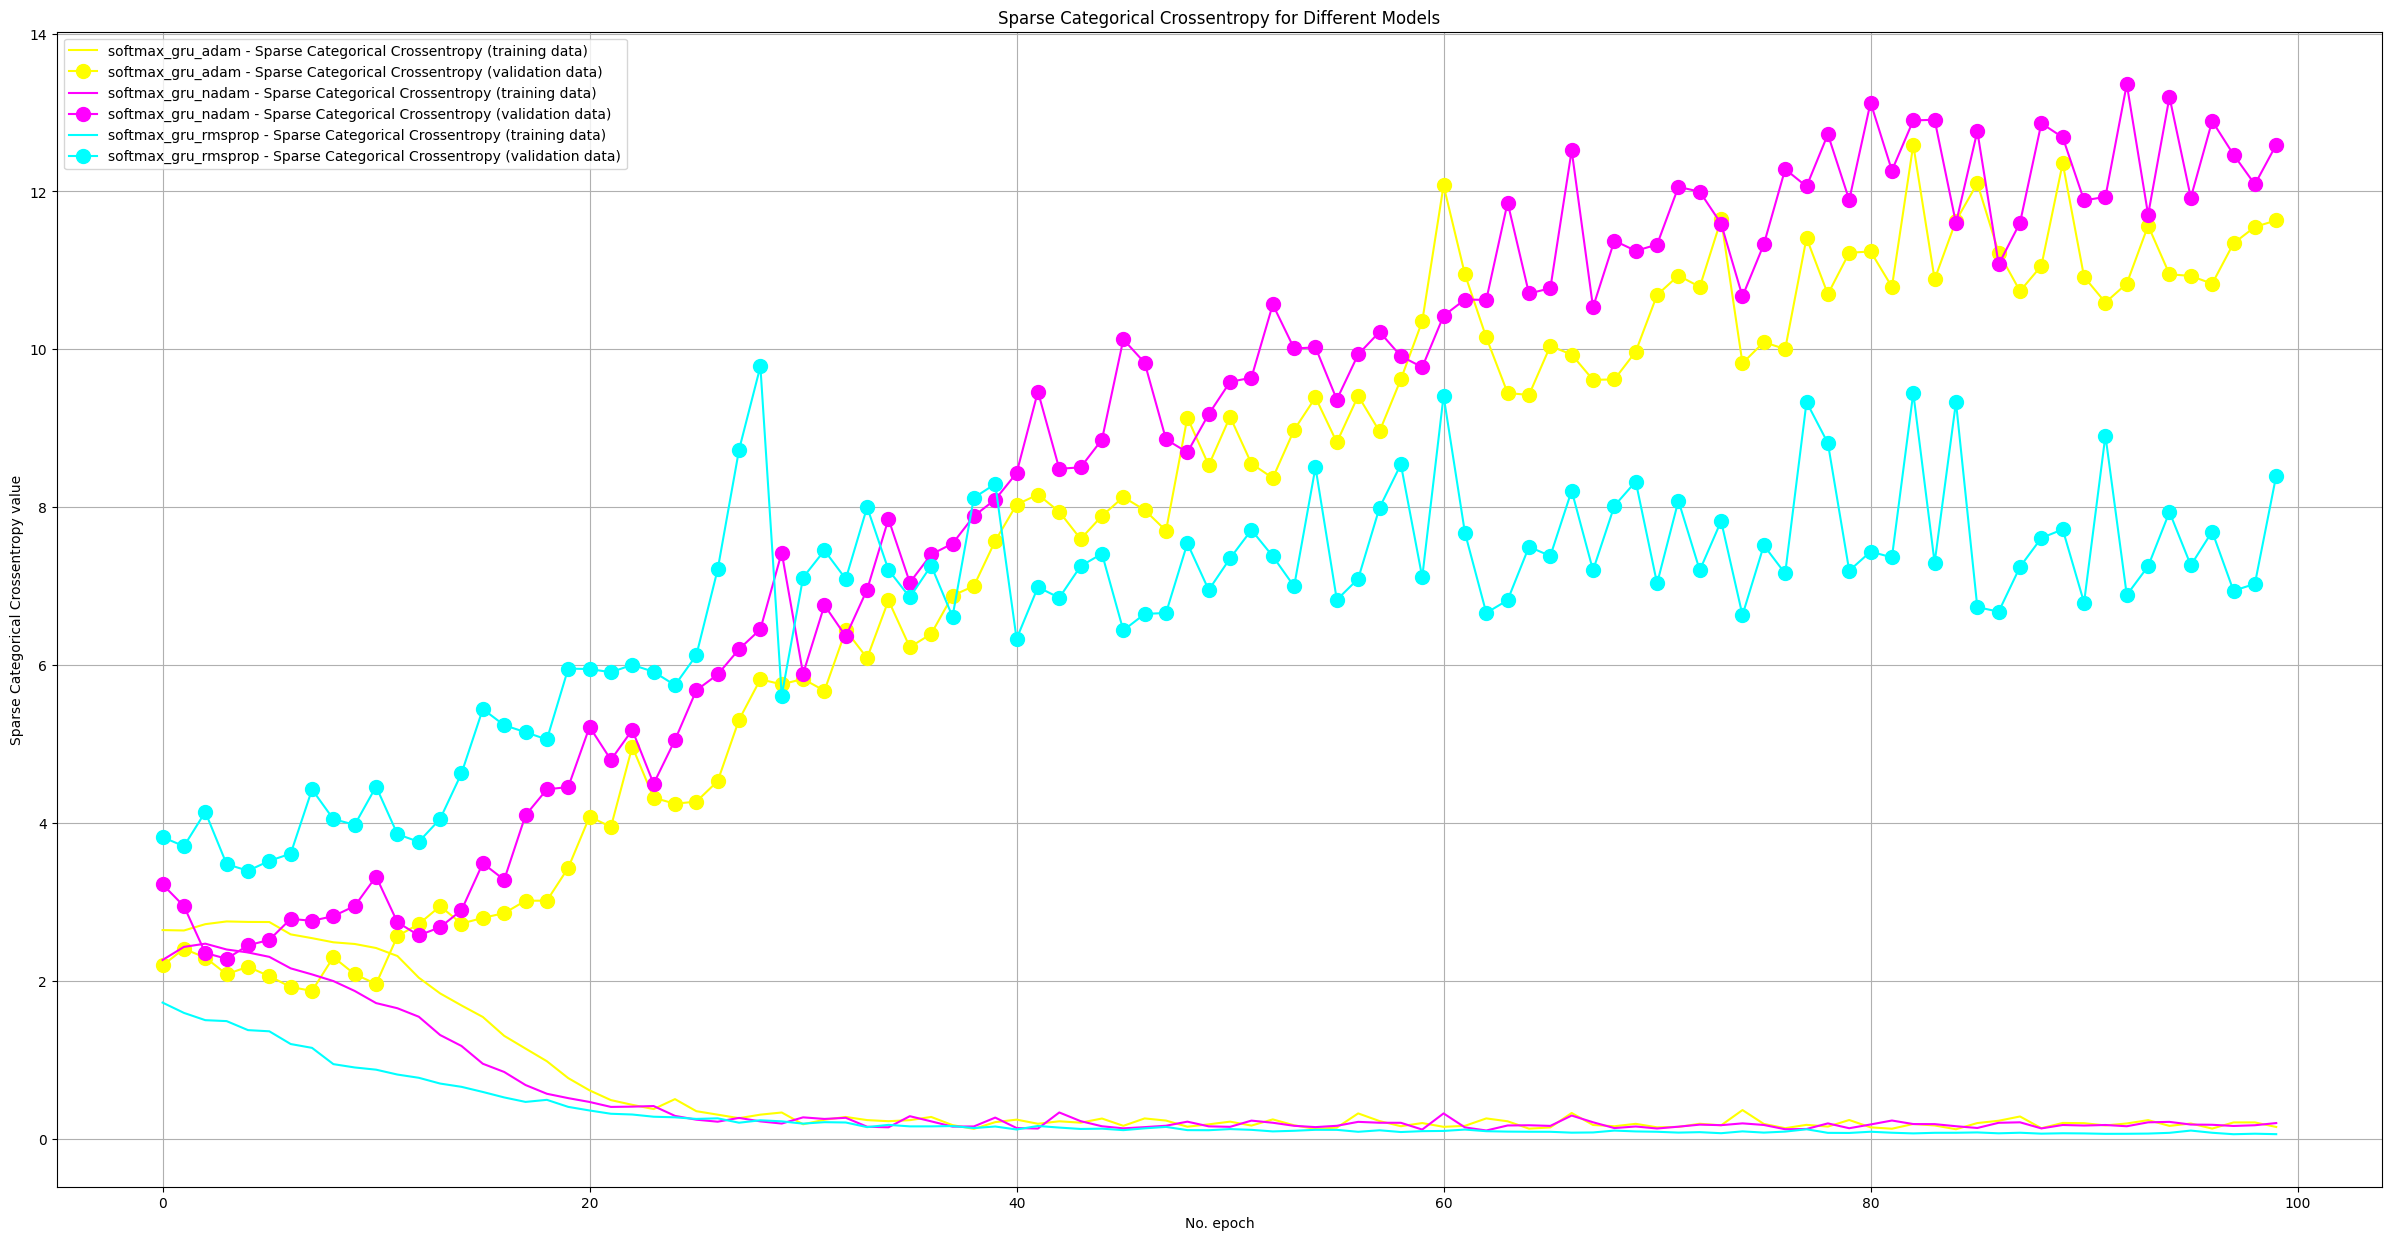

In [90]:
plt.rcdefaults()
plt.figure(figsize=(30,15))

for model_name in models_to_test:
    color_plot = models_to_test[model_name]["color_plot"]
    history = models_to_test[model_name]["history"]
    plt.plot(history.history['loss'], label=f'{model_name} - Sparse Categorical Crossentropy (training data)', color=color_plot)
    plt.plot(history.history['val_loss'], label=f'{model_name} - Sparse Categorical Crossentropy (validation data)', color=color_plot, marker=".", markersize=20)

plt.title('Sparse Categorical Crossentropy for Different Models')
plt.ylabel('Sparse Categorical Crossentropy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

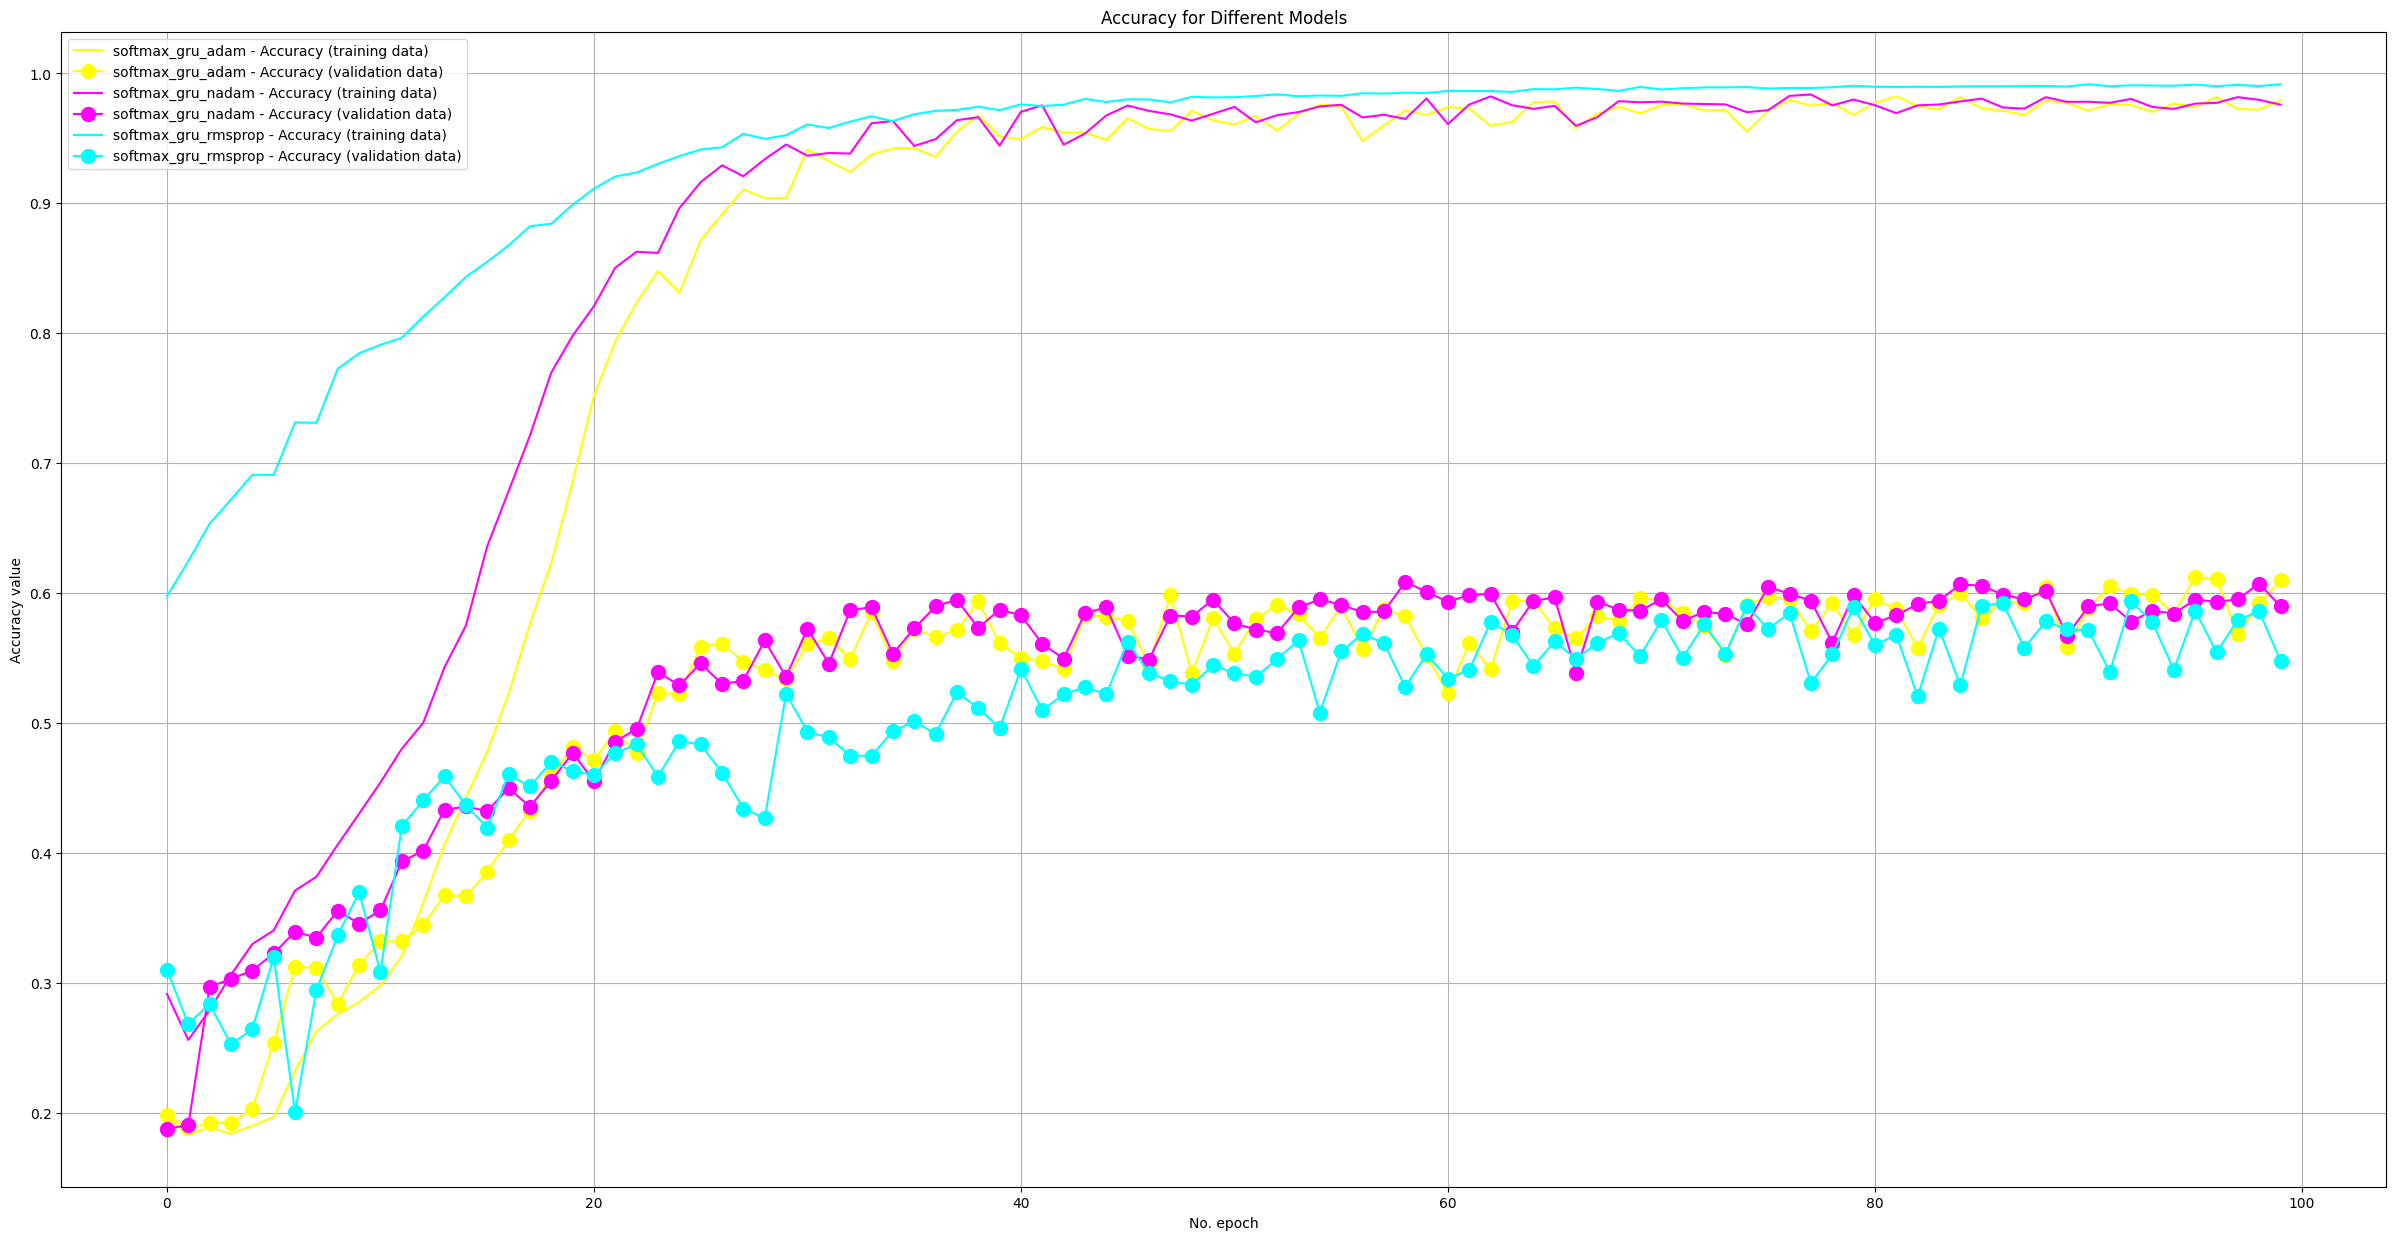

In [91]:
plt.rcdefaults()
plt.figure(figsize=(30,15))

for model_name in models_to_test:
    color_plot = models_to_test[model_name]["color_plot"]
    history = models_to_test[model_name]["history"]
    plt.plot(history.history['accuracy'], label=f'{model_name} - Accuracy (training data)', color=color_plot)
    plt.plot(history.history['val_accuracy'], label=f'{model_name} - Accuracy (validation data)', color=color_plot, marker=".", markersize=20)

plt.title('Accuracy for Different Models')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

In [92]:
# lstm_model.evaluate(
#     x=features_tensor,
#     y=targets_tensor
# )

## Making Predictions

In [93]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

In [94]:
labels = [
    "Not Defined/Transient",
    "Baseline",
    "Stress",
    "Amusement",
    "Meditation",
    "Error/Not Labeled"
]

In [95]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title(class_label)

In [96]:
len(model_features_validation)

5193

In [97]:
features_tensor_validation = convert_to_tensor(
    np.array(
        [convert_to_tensor(data) for data in model_features_validation]
    )
)


In [98]:
features_tensor_validation

<tf.Tensor: shape=(5193, 60, 5), dtype=float64, numpy=
array([[[-4.65943125e-02, -9.04284684e-01, -6.64559137e-01,
         -4.89919394e-01,  1.63959898e-01],
        [ 1.51342789e-01,  8.11712260e-01, -1.93284080e+00,
         -1.14633667e+00,  3.45247980e-01],
        [-4.70135591e-01, -1.04226242e-01, -8.41134923e-01,
         -2.13595033e+00, -7.00115834e-01],
        ...,
        [-8.91612405e-01, -1.07396680e+00, -1.87933942e+00,
         -1.39711654e+00, -4.30786096e-02],
        [ 6.48519759e-02, -7.52638404e-01, -2.67509237e+00,
          3.69179308e-01,  4.86917491e-01],
        [-9.09065533e-01, -7.63304895e-01, -7.24960597e-01,
          2.49215201e-01,  2.21087009e-01]],

       [[ 1.51342789e-01,  8.11712260e-01, -1.93284080e+00,
         -1.14633667e+00,  3.45247980e-01],
        [-4.70135591e-01, -1.04226242e-01, -8.41134923e-01,
         -2.13595033e+00, -7.00115834e-01],
        [ 1.06858273e-01,  1.07392247e+00, -2.10743732e+00,
         -9.96365130e-01,  1.30739834e

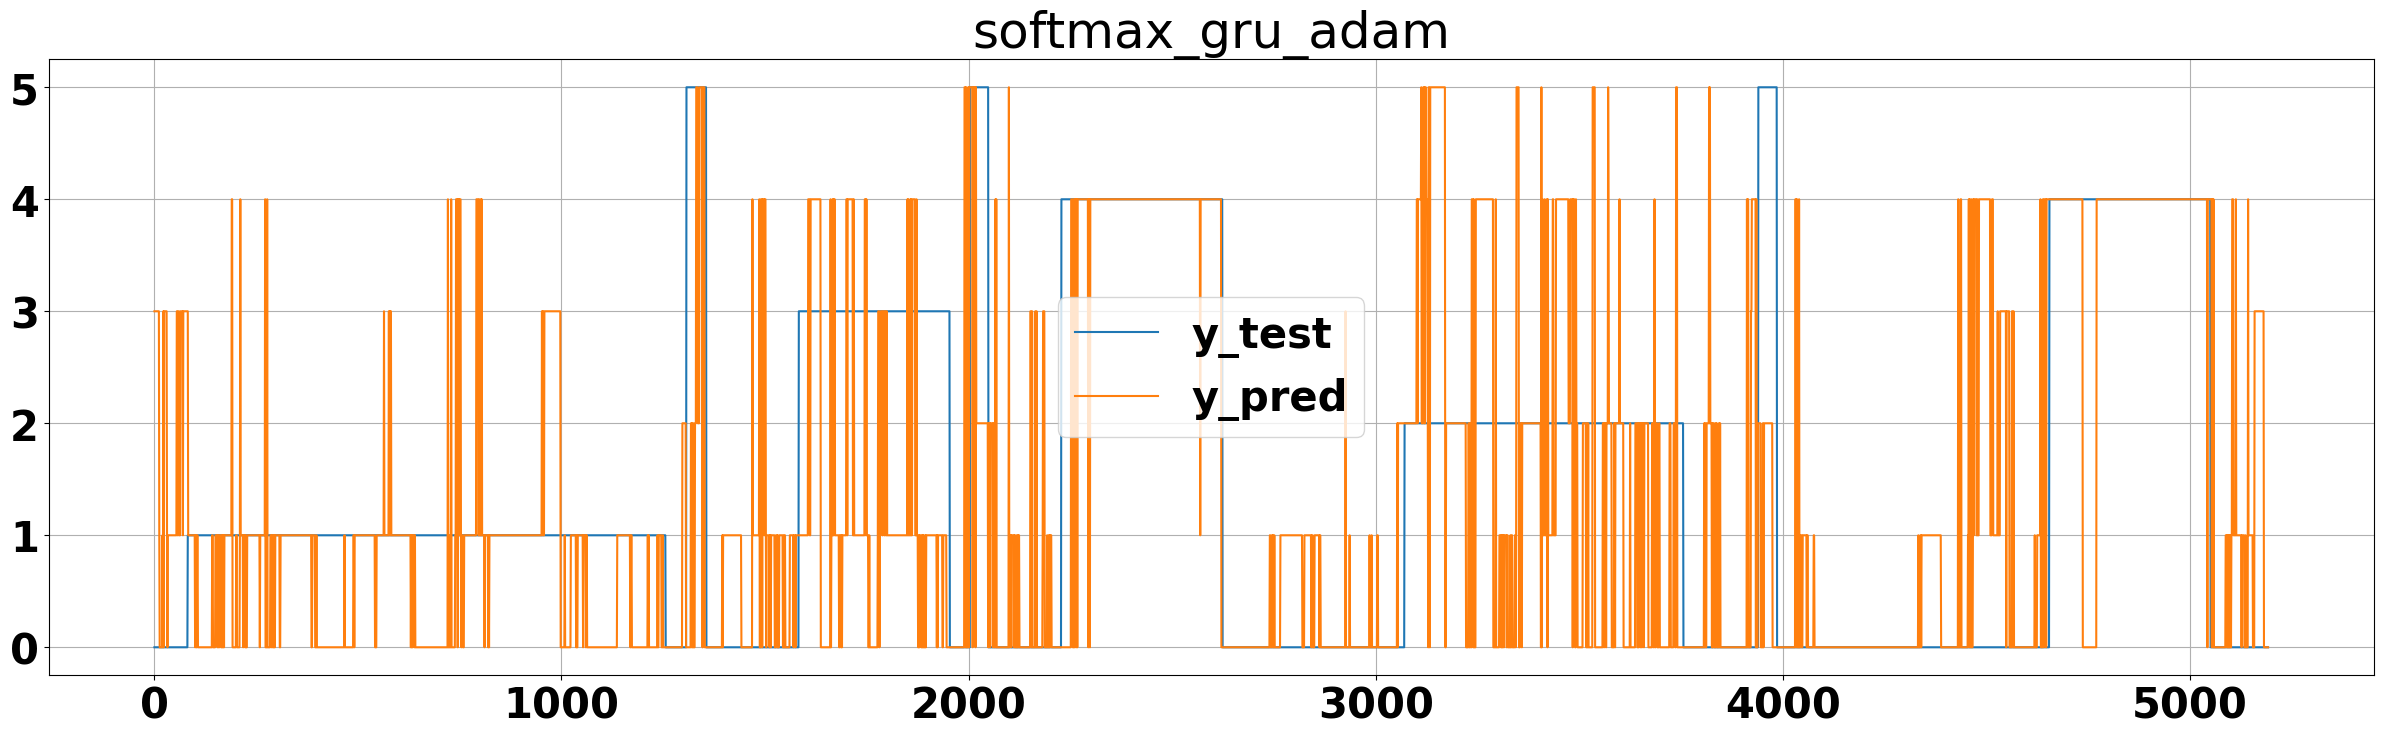

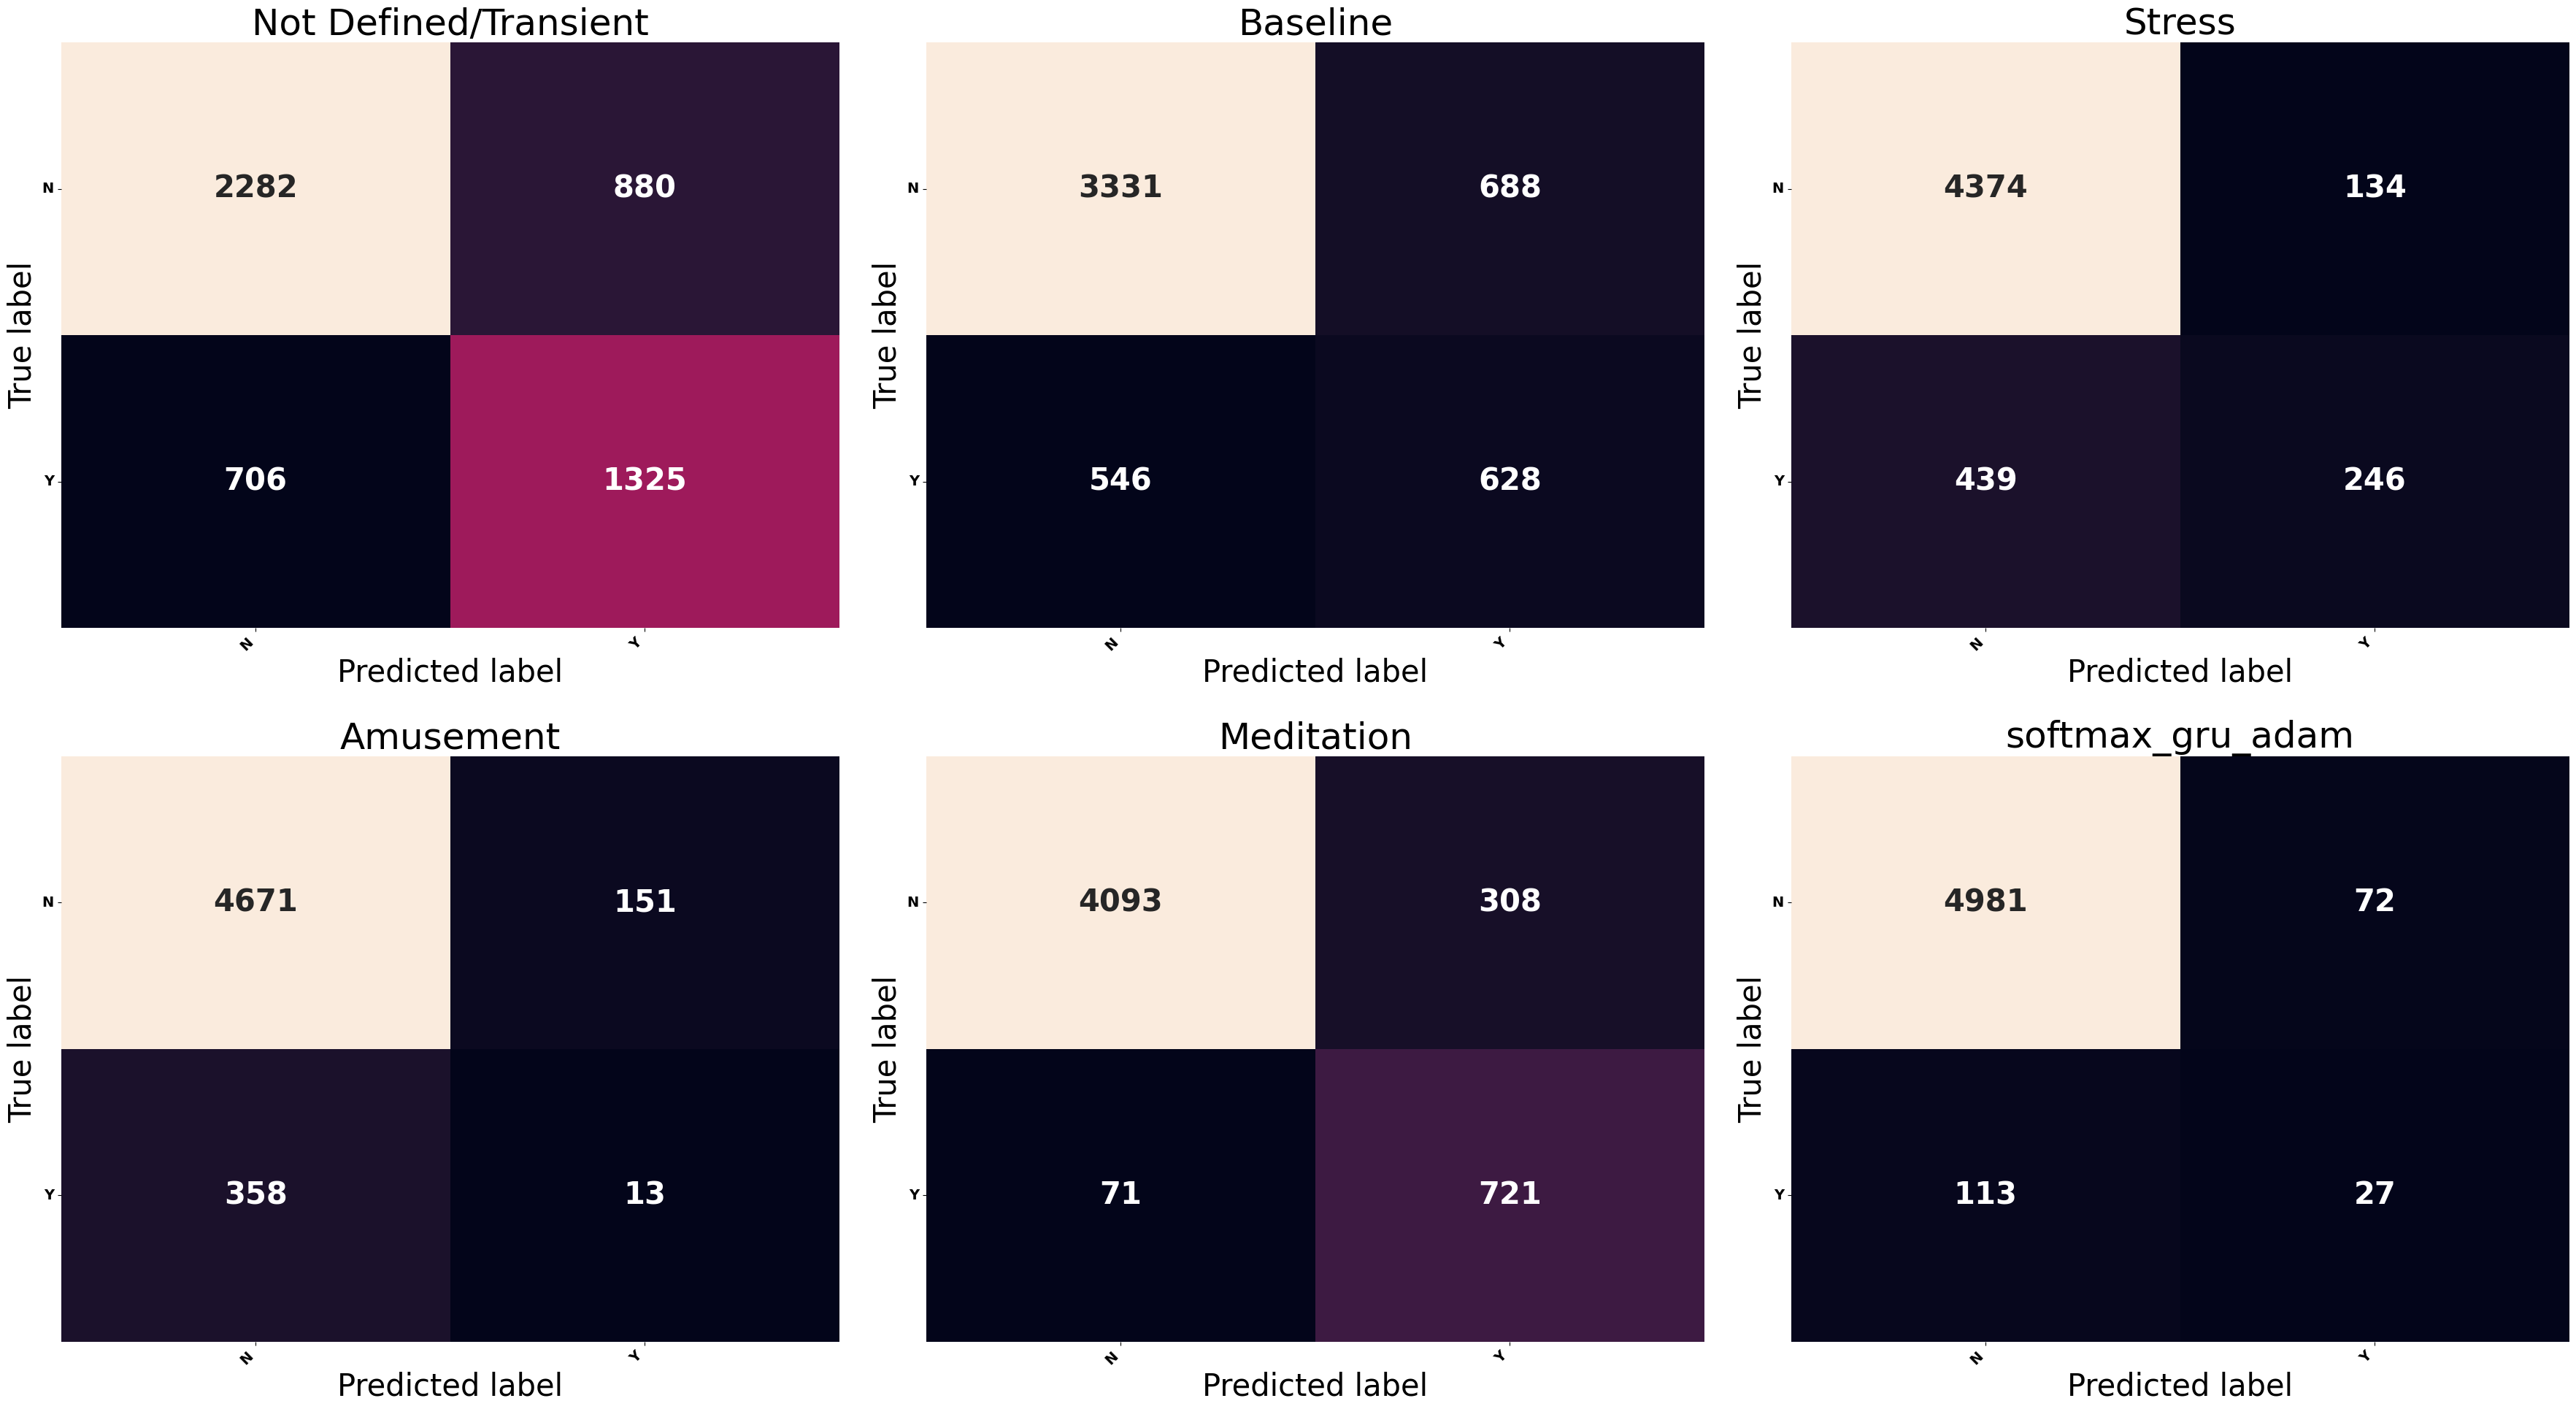

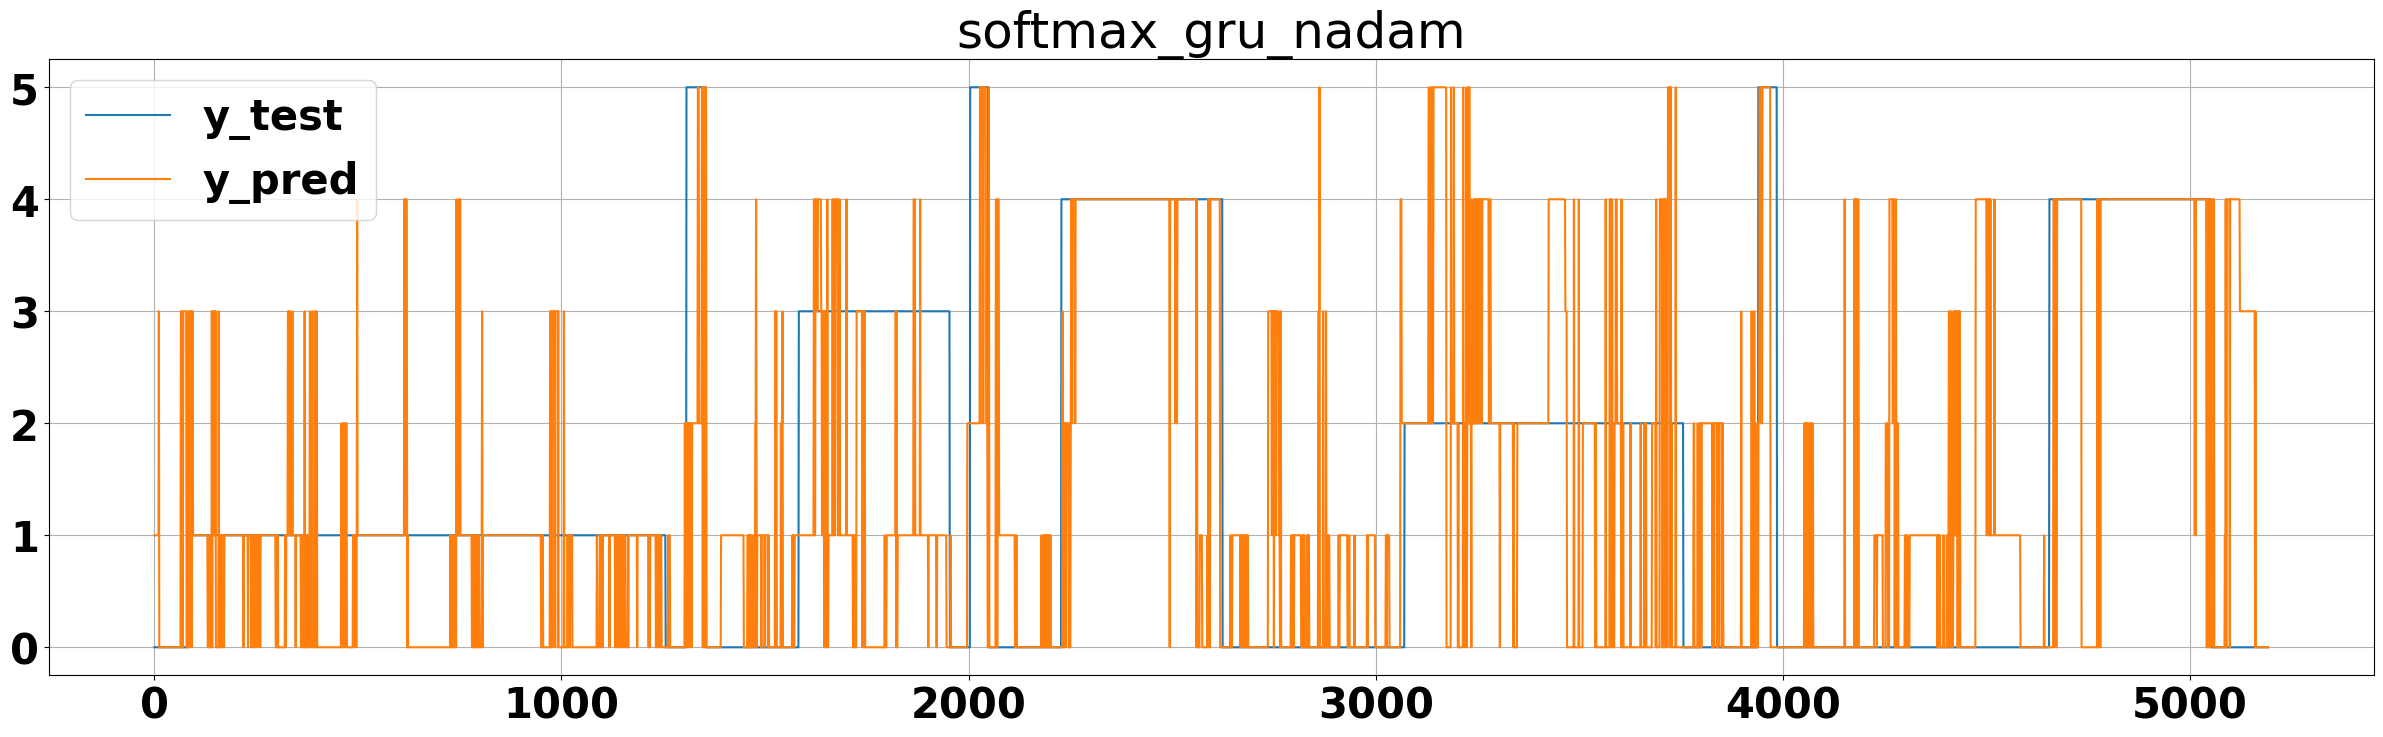

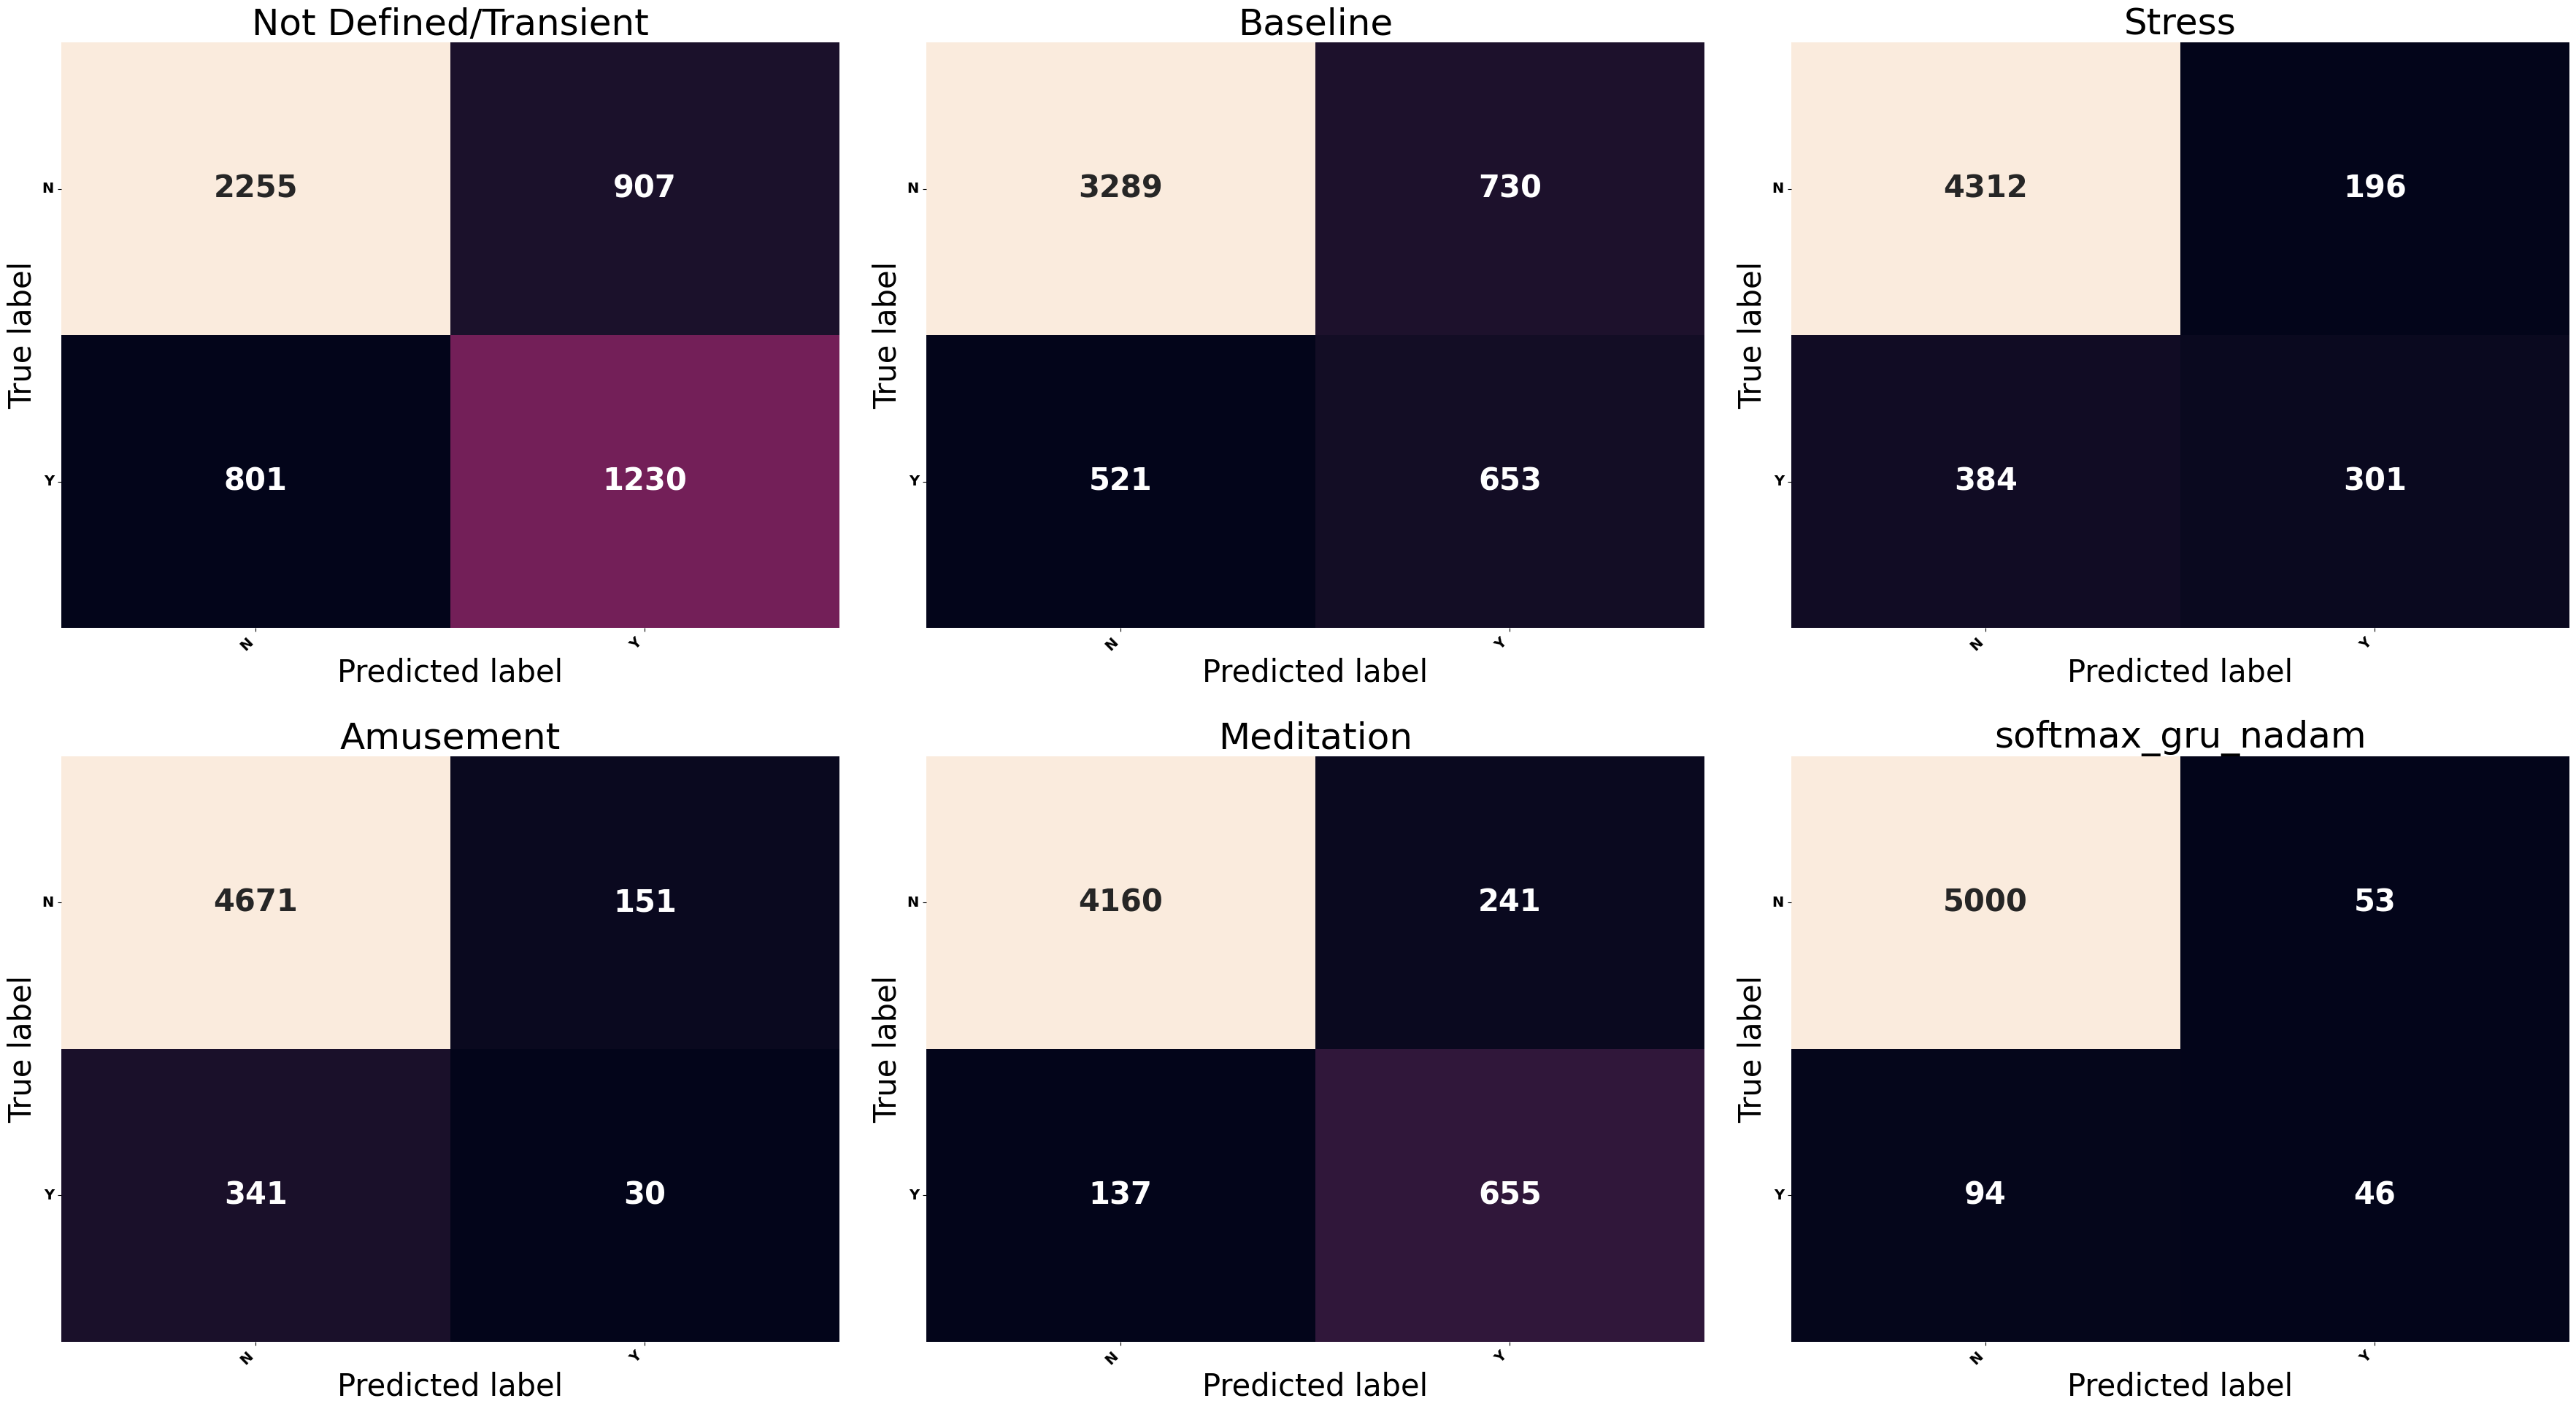

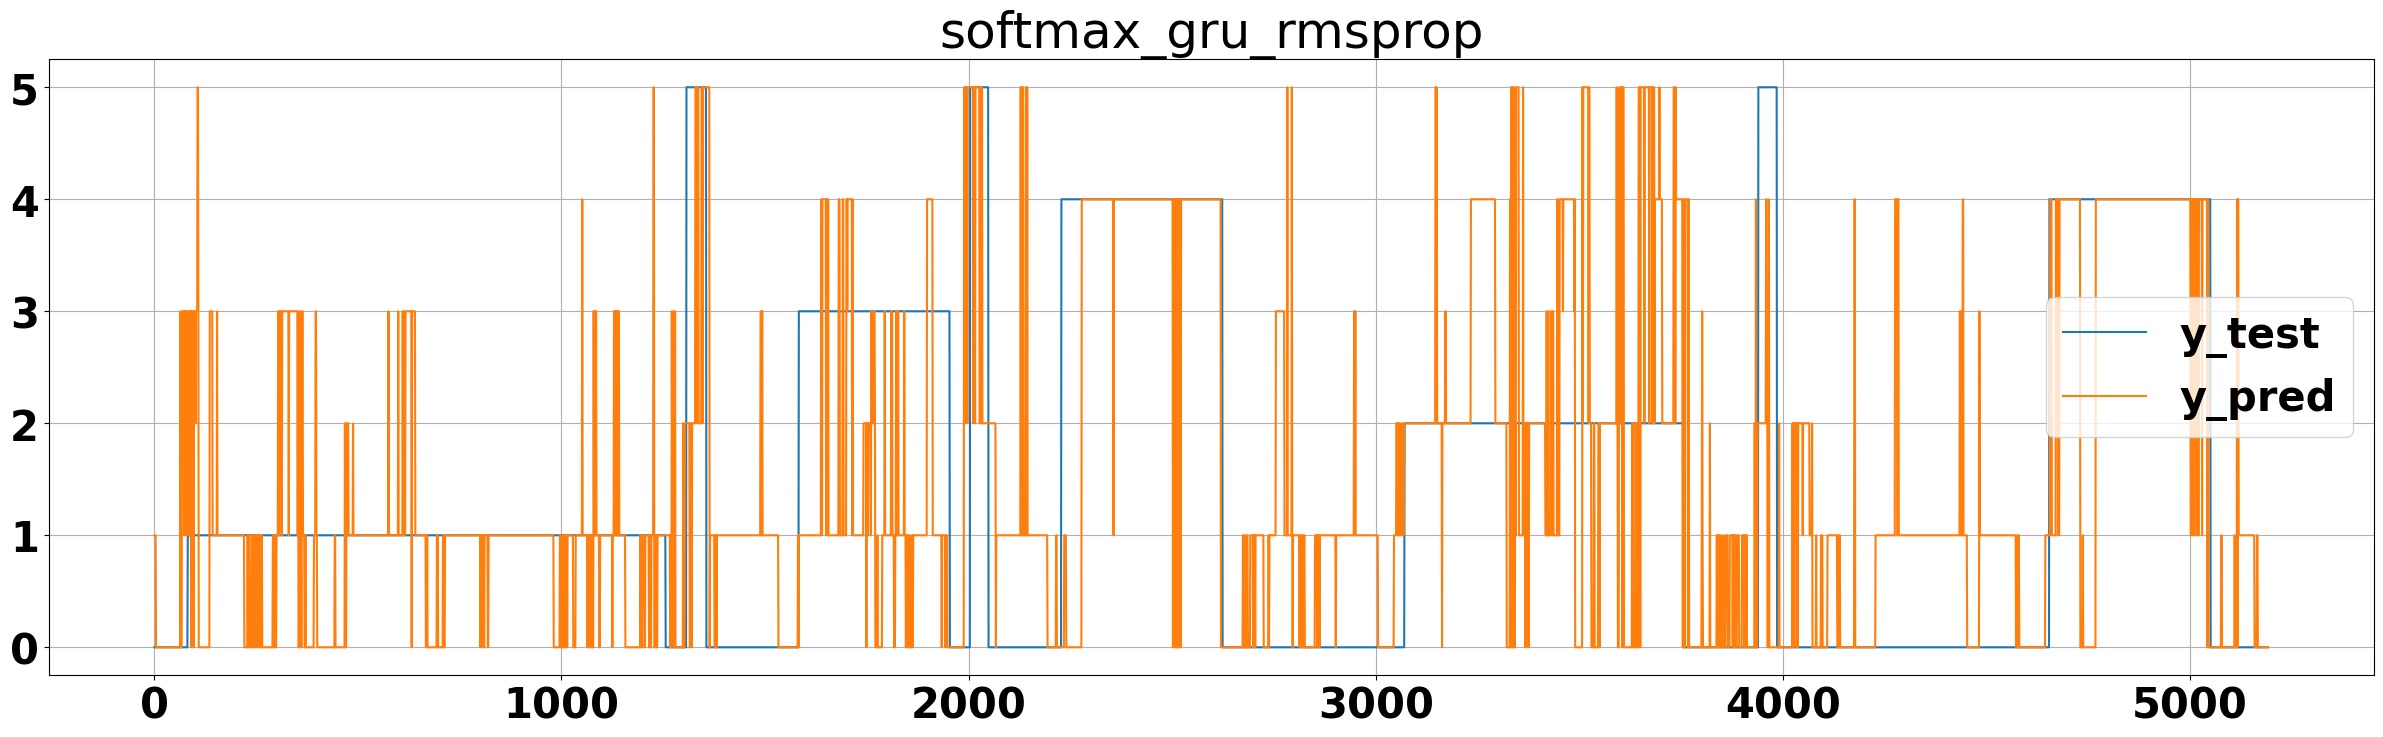

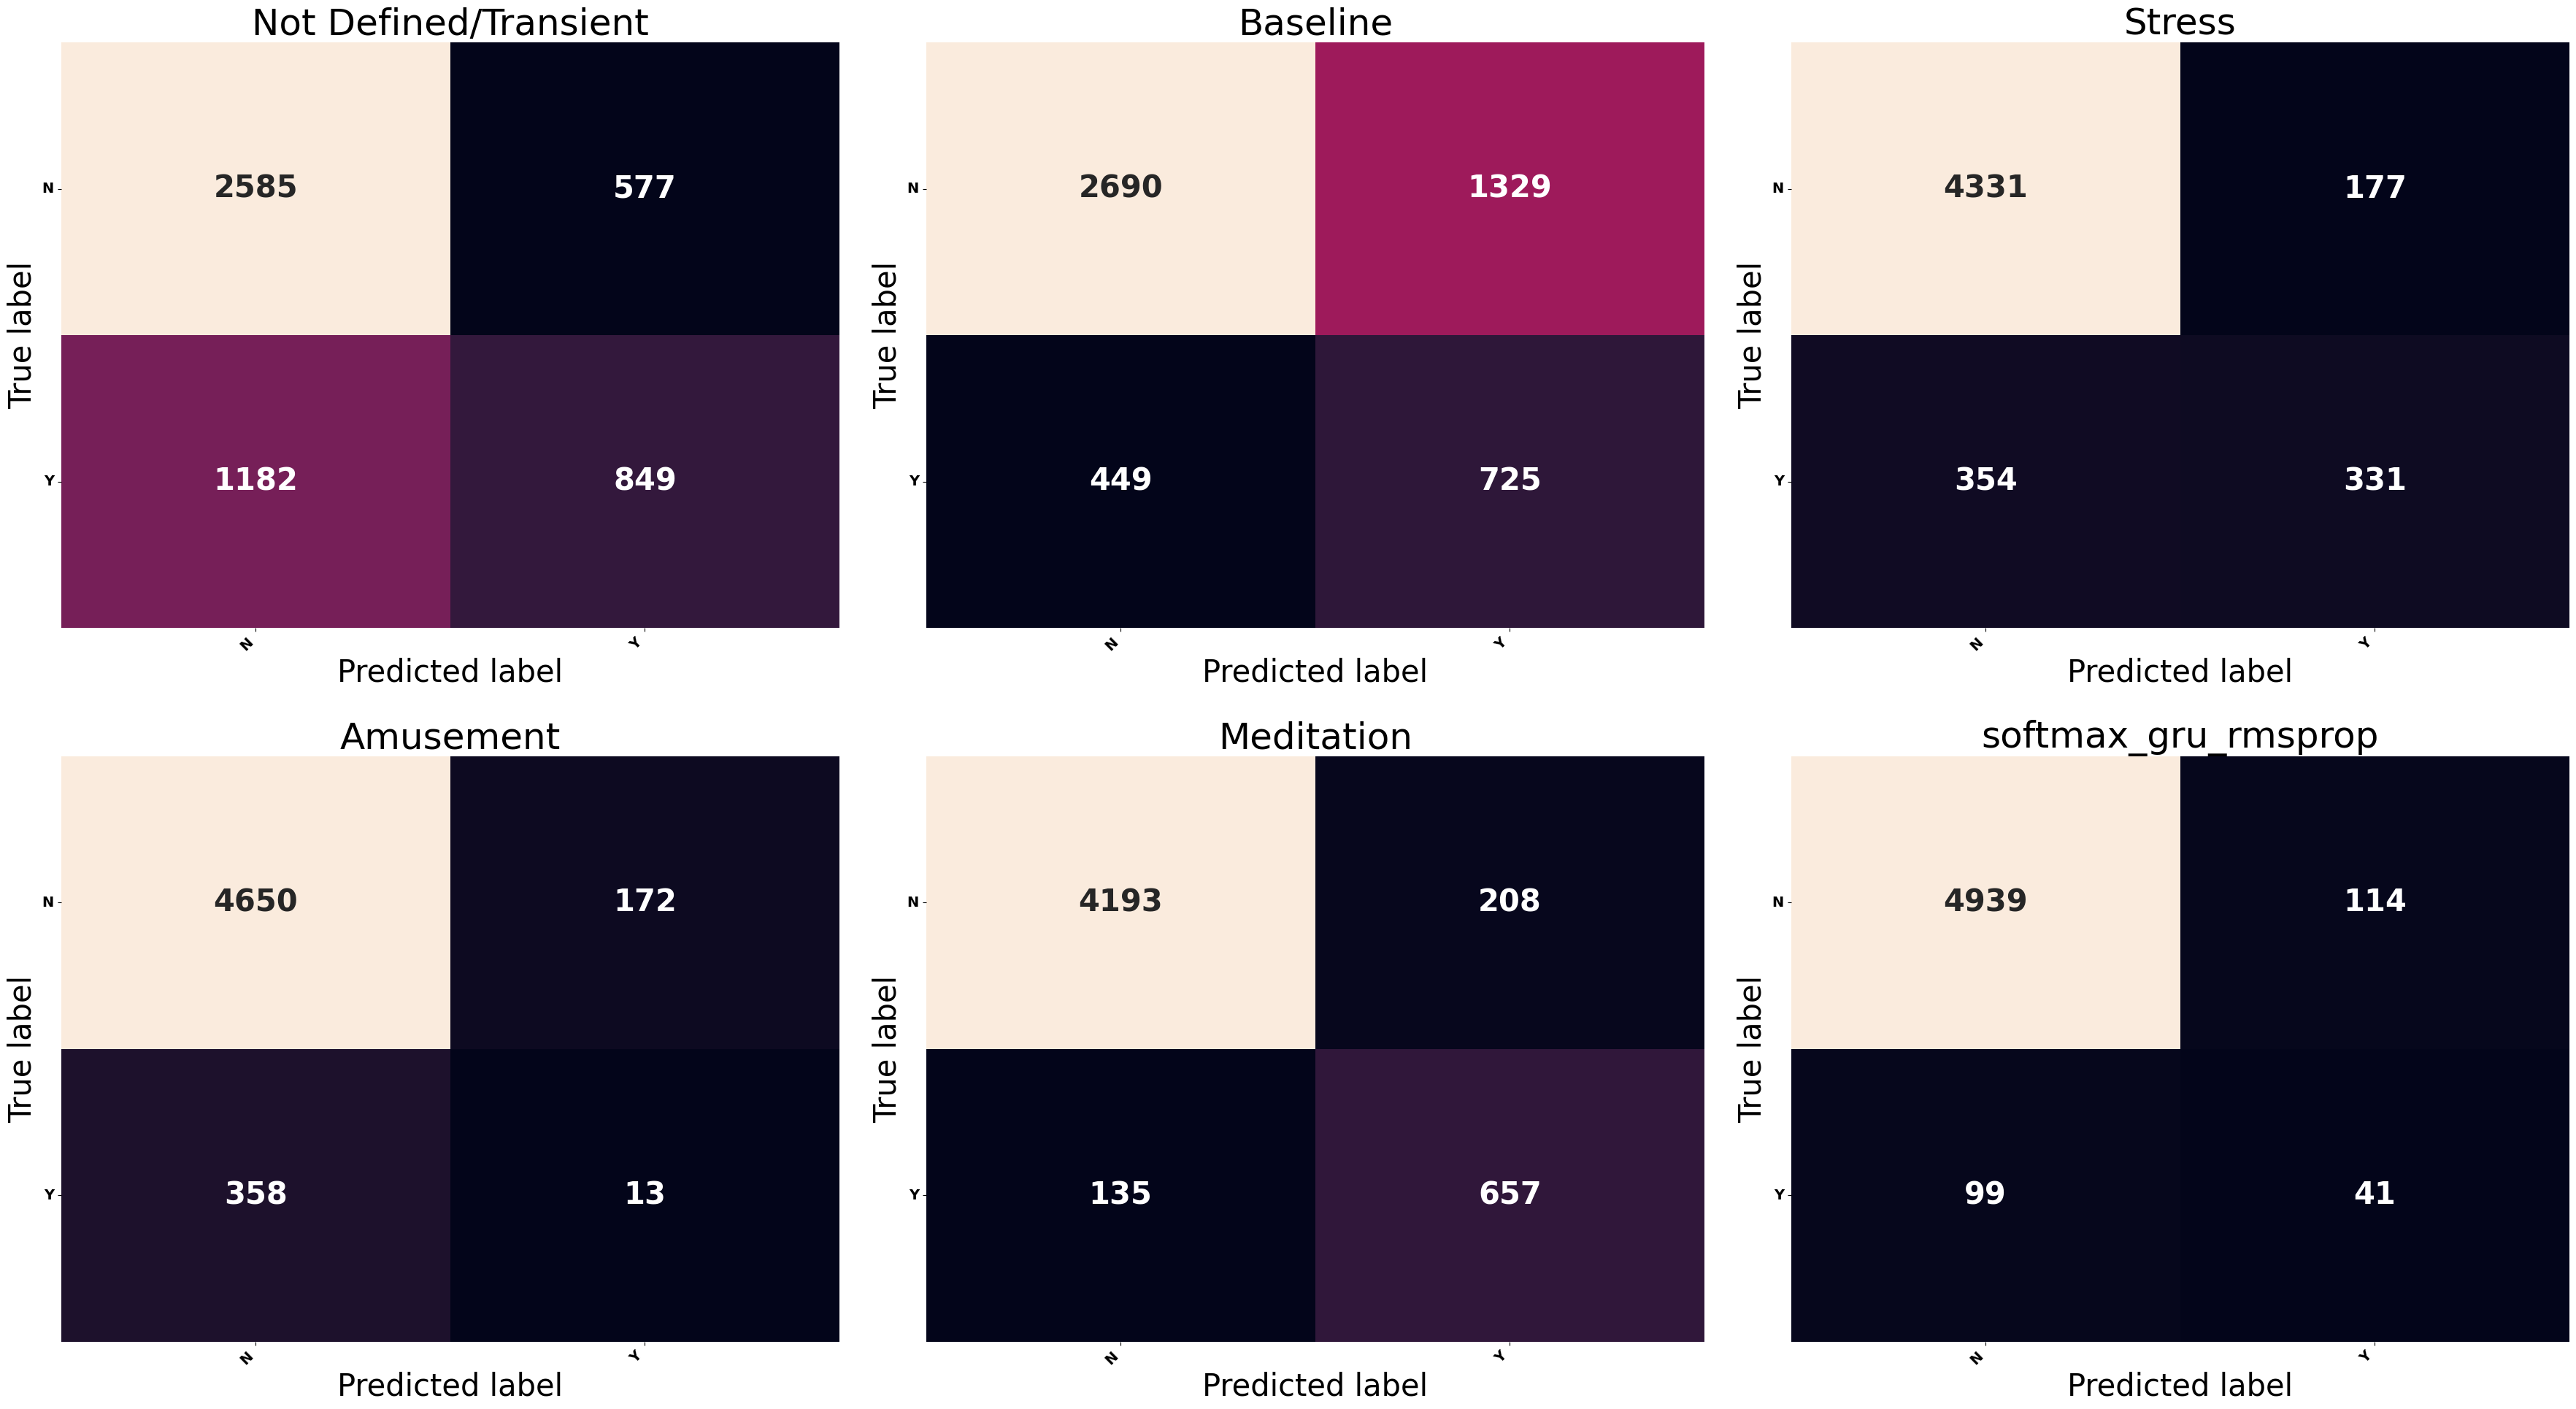

In [99]:
font = {'family' : 'normal',
            'weight' : 'bold',
            'size'   : 30}
plt.rc("font",**font)

y_test = model_targets_validation

for model_name in models_to_test:
    y_pred_prob = models_to_test[model_name]["model"].predict( x = features_tensor_validation )

    predictions = []
    for i in range(len(y_pred_prob)):
        predictions.append(np.argmax(y_pred_prob[i]))
    
    y_pred = np.array(predictions)
    models_to_test[model_name]["predictions"] = y_pred

    df_y = pd.DataFrame({
        "y_test": y_test,
        "y_pred": y_pred
    })

    models_to_test[model_name]["pred_image"] = df_y.plot(figsize=(30, 8), grid=True).get_figure()
    plt.title(model_name)

    y_test_label = np.array([pacient_state[i] for i in y_test])
    y_pred_label = np.array([pacient_state[i] for i in y_pred])

    confusion_matrix = multilabel_confusion_matrix(y_test_label, y_pred_label, labels=labels)

    models_to_test[model_name]["confusion_matrix"] = confusion_matrix

    fig, ax = plt.subplots(2, 3, figsize=(36, 20))

    for axes, cf_matrix, label in zip(ax.flatten(), confusion_matrix, labels):
        print_confusion_matrix(cf_matrix, axes, label, ["N", "Y"])
    fig.tight_layout()
    plt.title(model_name)
    
    models_to_test[model_name]["confusion_matrix_image"] = fig

In [100]:
models_to_test

{'softmax_gru_adam': {'has_activator': True,
  'activator_layer': 'softmax',
  'color_plot': 'yellow',
  'layers': <function __main__.gru(model=None)>,
  'optimizer': 'adam',
  'callbacks': [<keras.callbacks.TensorBoard at 0x16ff876d0>],
  'history': <keras.callbacks.History at 0x170076fd0>,
  'model': <keras.engine.sequential.Sequential at 0x16fca37c0>,
  'predictions': array([3, 3, 3, ..., 0, 0, 0]),
  'pred_image': <Figure size 3000x800 with 1 Axes>,
  'confusion_matrix': array([[[2282,  880],
          [ 706, 1325]],
  
         [[3331,  688],
          [ 546,  628]],
  
         [[4374,  134],
          [ 439,  246]],
  
         [[4671,  151],
          [ 358,   13]],
  
         [[4093,  308],
          [  71,  721]],
  
         [[4981,   72],
          [ 113,   27]]]),
  'confusion_matrix_image': <Figure size 3600x2000 with 6 Axes>},
 'softmax_gru_nadam': {'has_activator': True,
  'activator_layer': 'softmax',
  'color_plot': 'magenta',
  'layers': <function __main__.gru(model

## Testing Area

In [101]:
# sigmoid_predictions = models_to_test["sigmoid"]["predictions"]
softmax_predictions = models_to_test["softmax"]["predictions"]
# no_activator_predictions = models_to_test["no_activatior"]["predictions"]

KeyError: 'softmax'

In [ ]:
# sigmoid_predictions
softmax_predictions
# no_activator_predictions

In [ ]:
softmax_predictions.shape

In [ ]:
sum(softmax_predictions[0])

In [ ]:
predictions = []
for i in range(len(softmax_predictions)):
    predictions.append(np.argmax(softmax_predictions[i]))

In [ ]:
len(predictions)

In [ ]:
predictions_array = np.array(predictions)

In [ ]:
predictions_array

In [ ]:
model_targets_validation

In [ ]:
targets_tensor_validation = tf.convert_to_tensor(model_targets_validation, dtype="int64")

In [ ]:
test_loss, test_acc = model.evaluate(features_tensor_validation, targets_tensor_validation, verbose=2)

print('\nTest accuracy:', test_acc)

In [ ]:
df_y = pd.DataFrame({
    "y_test": model_targets_validation,
    "y_pred": predictions_array
})

df_y.head(10)

In [ ]:
df_y.plot(figsize=(30, 8), grid=True)

In [ ]:
np.argmax(no_activator_predictions[0])

In [ ]:
max(no_activator_predictions)

In [ ]:
plt.figure(figsize=(30,5))
plt.plot(range(len(no_activator_predictions)) ,no_activator_predictions)


In [ ]:
# sigmoid_predictions[0]
softmax_predictions[0]

In [ ]:
# sigmoid_predictions[1]
softmax_predictions[1]

In [ ]:
def test_predictions(predictions_test, num_labels):
    label_index_teste = np.argmax(predictions_test[0][:num_labels])
    state_index_teste = np.argmax(predictions_test[0][num_labels:])

    for array in predictions_test:
        if (label_index_teste != np.argmax(array[:num_labels])) and (state_index_teste != np.argmax(array[num_labels:])):
            print("Exist at least one different prediction")
            return
    print("Does not exist different predictions")


In [ ]:
test_predictions(softmax_predictions, num_labels)

In [ ]:
test_predictions(sigmoid_predictions, num_labels)

In [ ]:
test_predictions(no_activator_predictions, num_labels)

In [ ]:
def transform_prediction(prediction_np, num_states, num_labels):
    zeros_base_array = np.zeros(num_labels + num_states)

    label_index = np.argmax(prediction_np[:num_labels])
    state_index = np.argmax(prediction_np[num_labels:])

    zeros_base_array[label_index] = 1
    zeros_base_array[num_labels + state_index] = 1

    return zeros_base_array

In [ ]:
transformed_array_list = []


for prediction in sigmoid_predictions:
    binary_array = transform_prediction(prediction, num_states, num_labels).reshape(1, num_states + num_labels)
    transformed_array_list.append(binary_array)


In [ ]:
fittable_econder_array = np.concatenate(transformed_array_list, axis=0)

In [ ]:
unique_values = np.unique(fittable_econder_array, axis=0)

unique_values

In [ ]:
enc.inverse_transform(fittable_econder_array)

In [ ]:
enc.get_feature_names()

In [ ]:
target_validation_array_list = []

for array in model_targets_validation:
    target_validation_array_list.append(array.reshape(1,14))

target_validation_array = np.concatenate(target_validation_array_list, axis=0)

In [ ]:
target_validation_array

In [ ]:
target_validation_array[0]

In [ ]:
target_validation_array[1]

In [ ]:
unique_values1 = np.unique(target_validation_array, axis=0)

unique_values1

In [ ]:
np.concatenate(target_validation_array_list, axis=0)

In [ ]:
labeled_validation = enc.inverse_transform(model_targets_validation.tolist())

In [ ]:
labeled_validation